In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_134269/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import os
os.chdir('../')
import torch
import pandas as pd
import numpy as np
import yaml
from sklearn import decomposition
from harmony import harmonize
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm
from tqdm import tqdm
import utils.label_dict
from utils.label_dict import protein_to_num_single_cells
from utils.analysis_utils import plot_UMAP, get_embeddings, create_cell_comparison, create_protein_hierarchy, get_gene_heterogeneity_enrichement, plot_gene_heterogeneity_enrichement, get_heterogeneity_df, scale, get_heterogeneousity_per_whole_image, get_col_matrix
from scipy.spatial.distance import pdist, cdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from seaborn import clustermap
from skimage import io
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import scanpy as sc
from scipy.sparse.linalg import eigs
from scipy.stats import ttest_ind, zscore, norm

cmap = cm.nipy_spectral


In [4]:
def get_reduced_features(features, n_components=100):
    pca = decomposition.PCA(n_components=n_components)
    pca = pca.fit(features)
    print(sum(pca.explained_variance_ratio_))
    return pca.transform(features)


def get_harmonized_features(features, df, key):
    return harmonize(torch.Tensor(features).numpy(), 
                                    df,
                                    batch_key = key, 
                                    use_gpu=True,
                                    random_state=42,
    )



def get_averaged_features(df, features, labels, sort=True):
    mat, columns = get_col_matrix(df, labels)
    averaged_features = []
    for key in range(len(columns)):
        indices = np.where((mat[:,key] == 1) & (mat.sum(axis=1) == 1))
        averaged_features.append(features[indices].mean(axis=0))
    averaged_features = torch.stack(averaged_features)
    return averaged_features, columns


### Create UMAPs

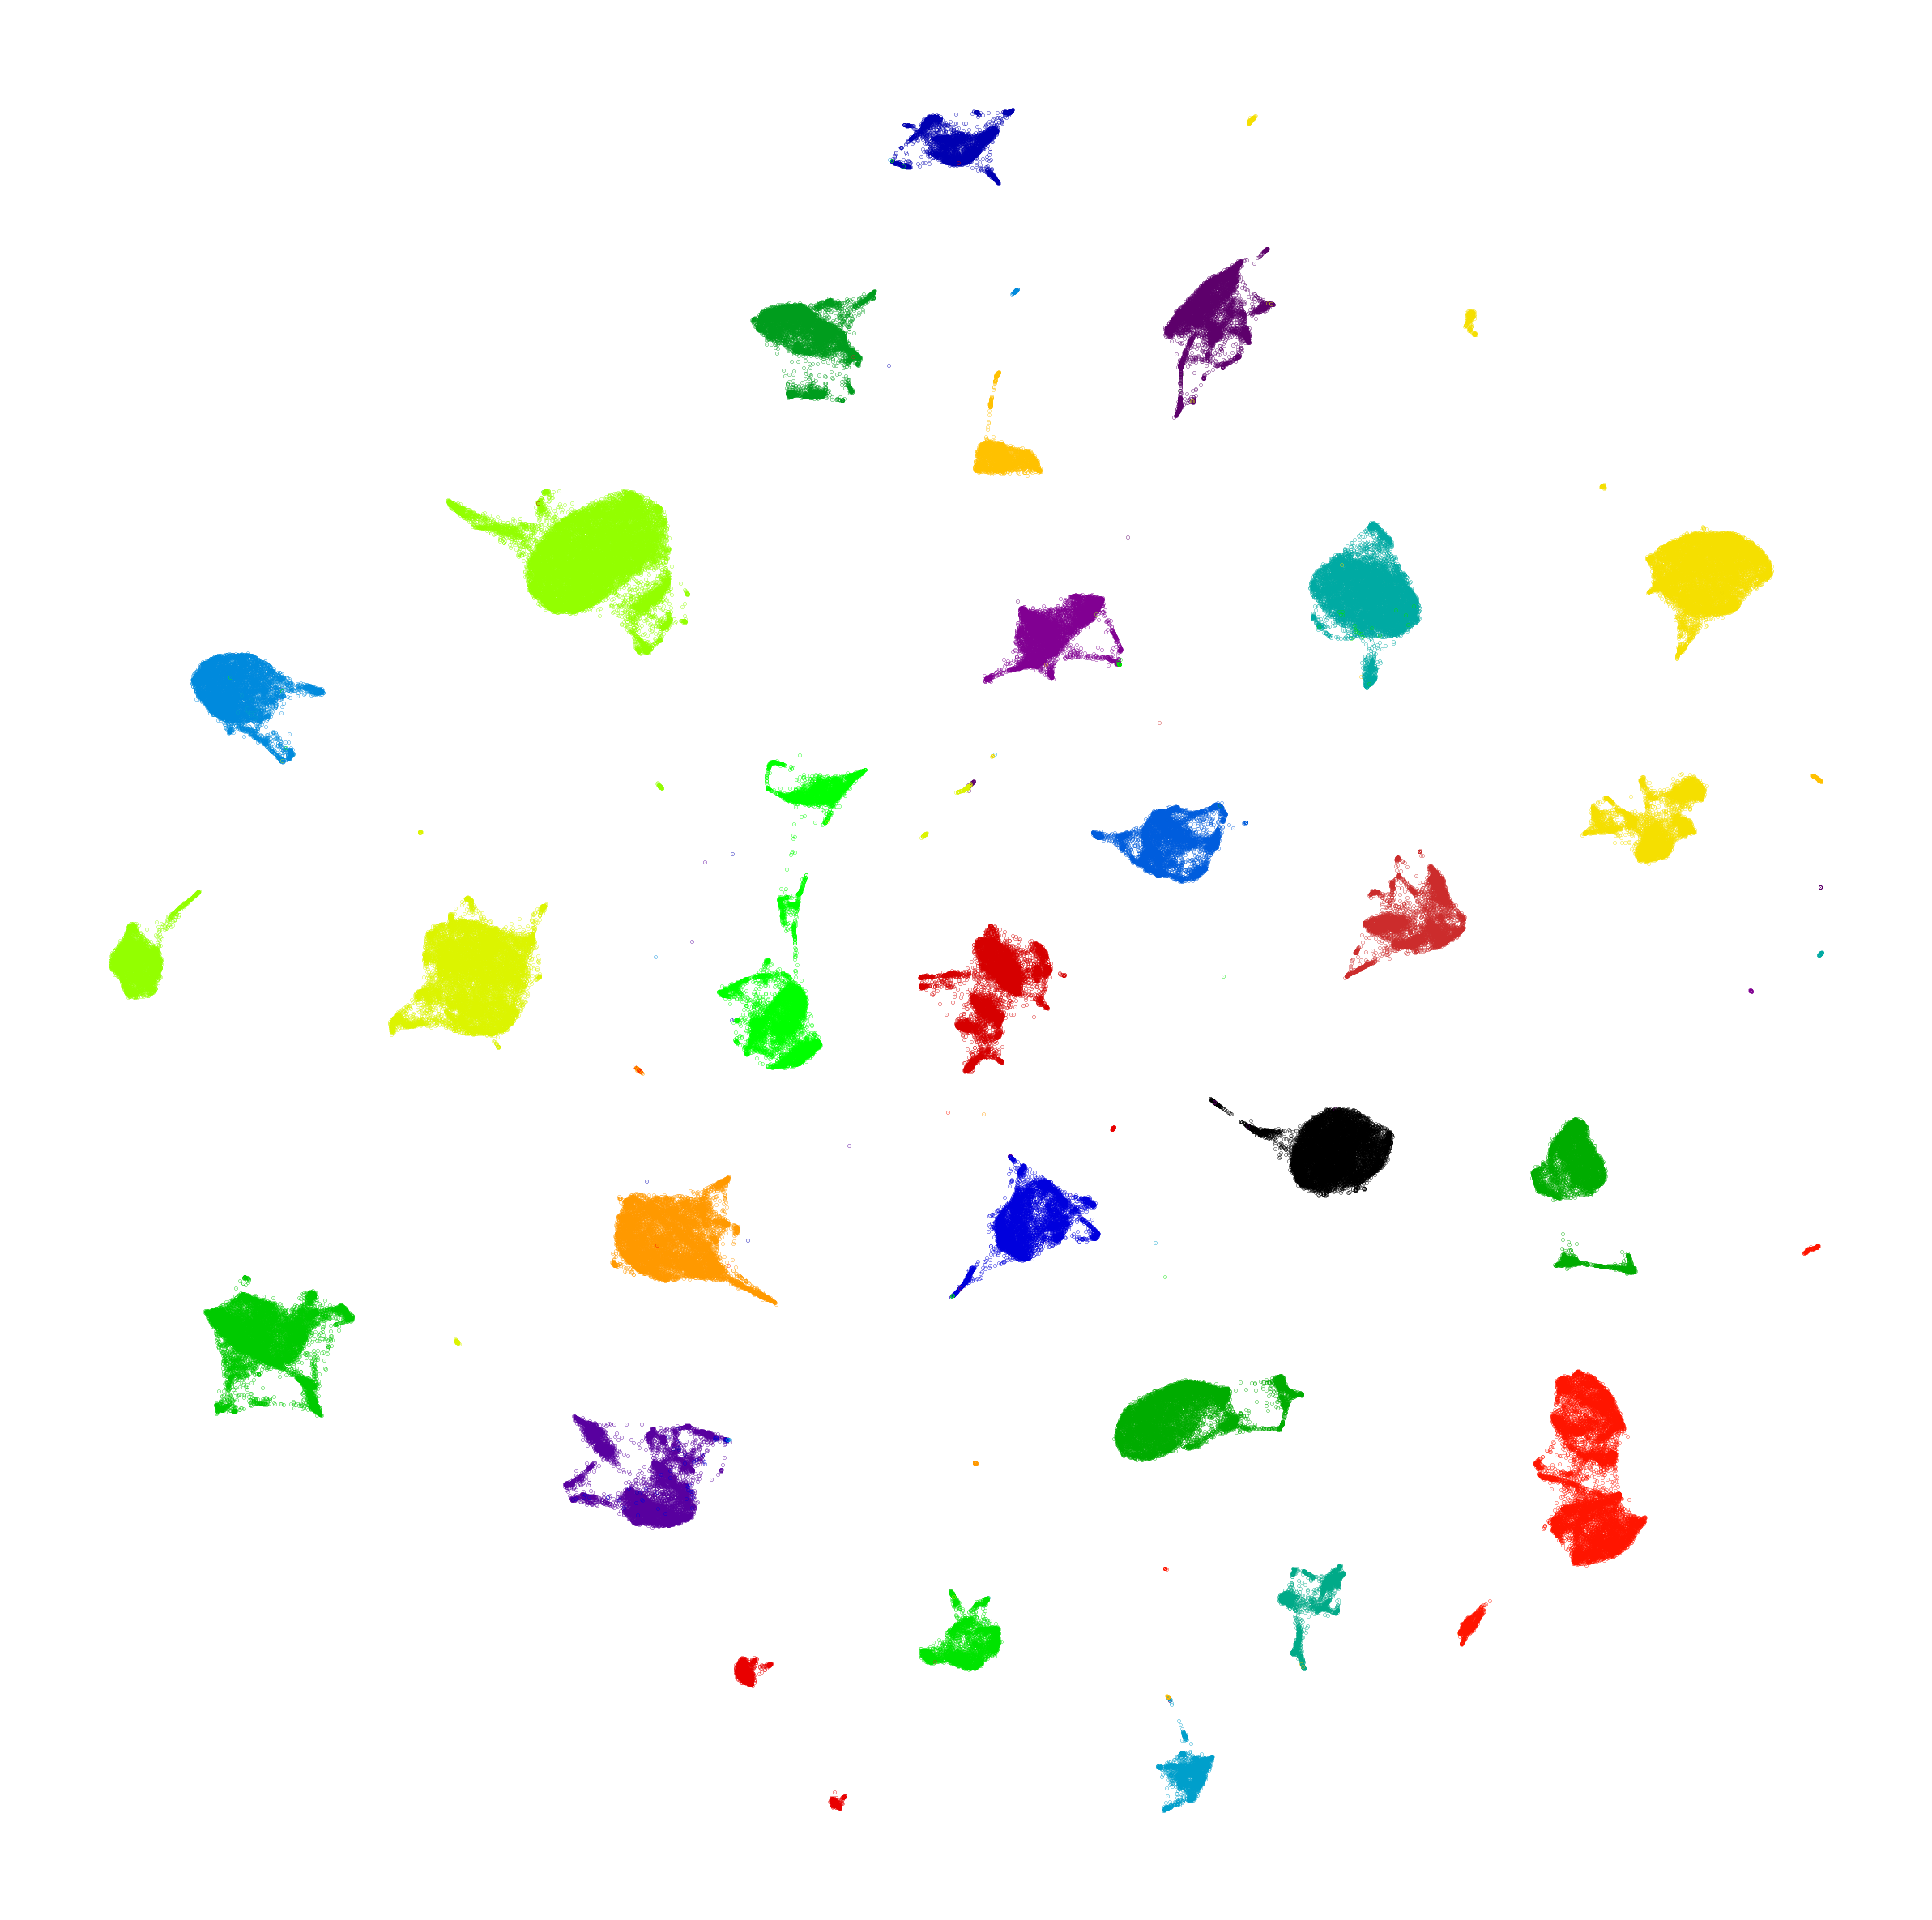

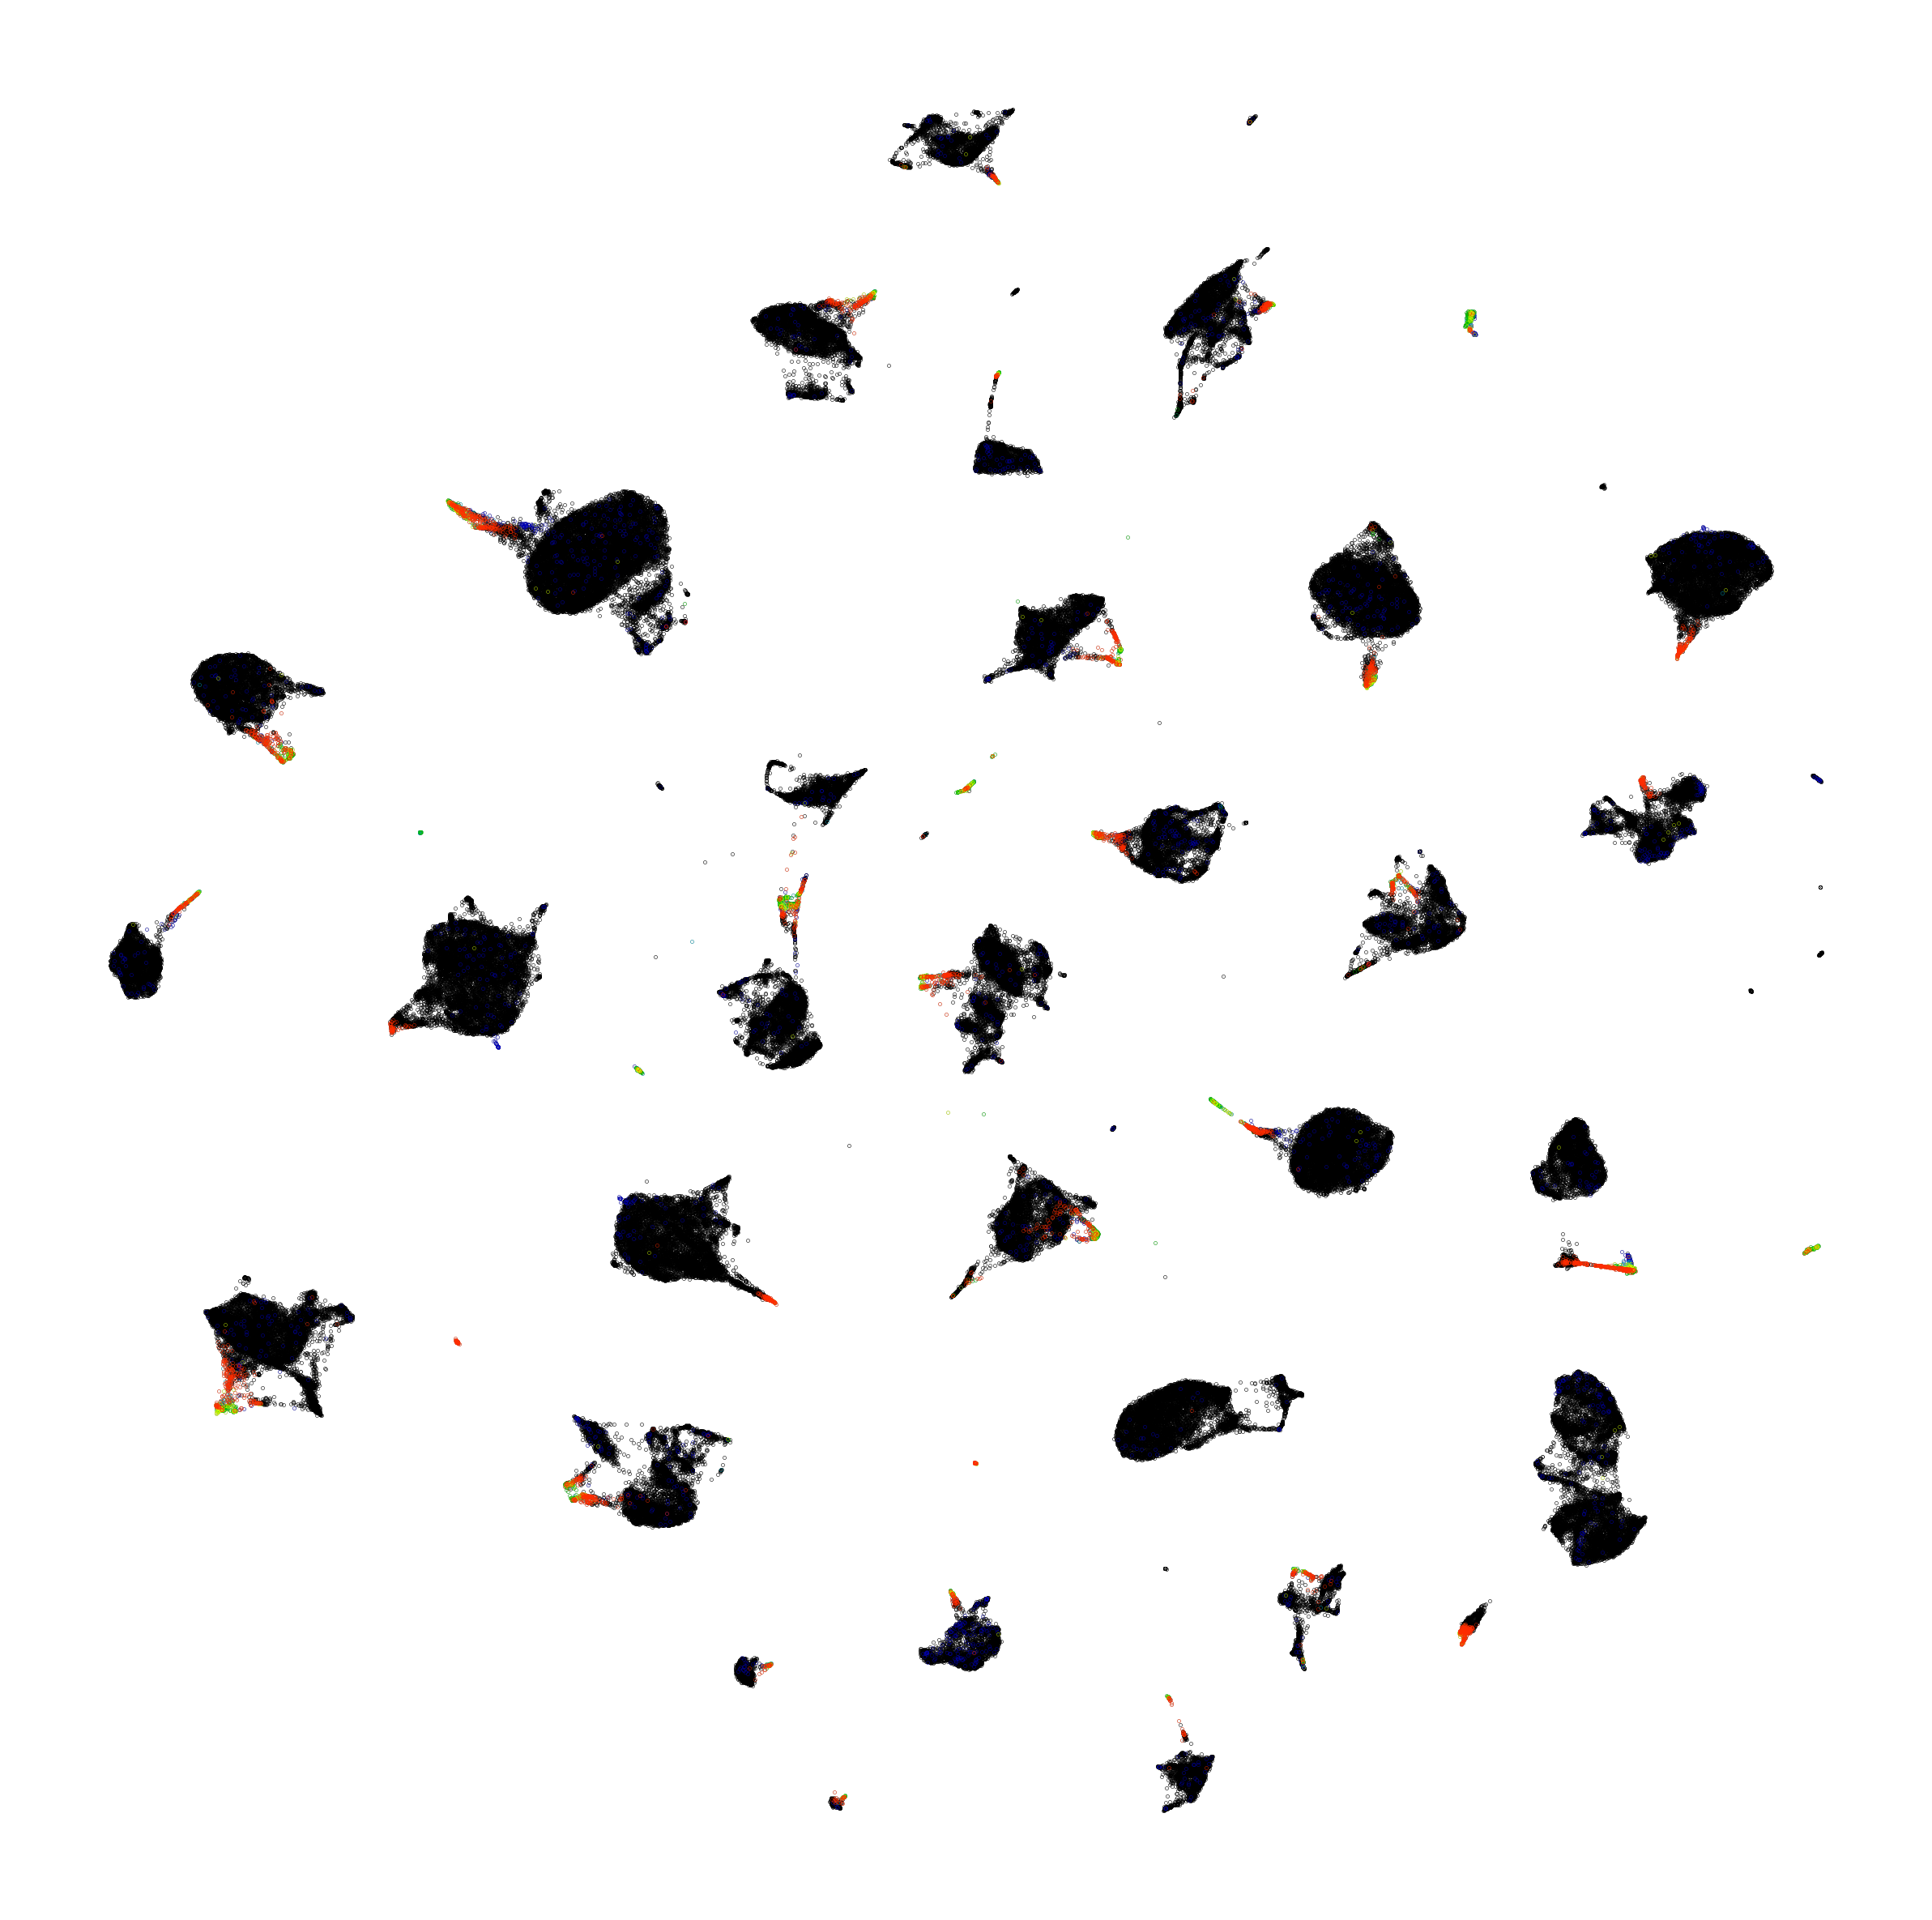

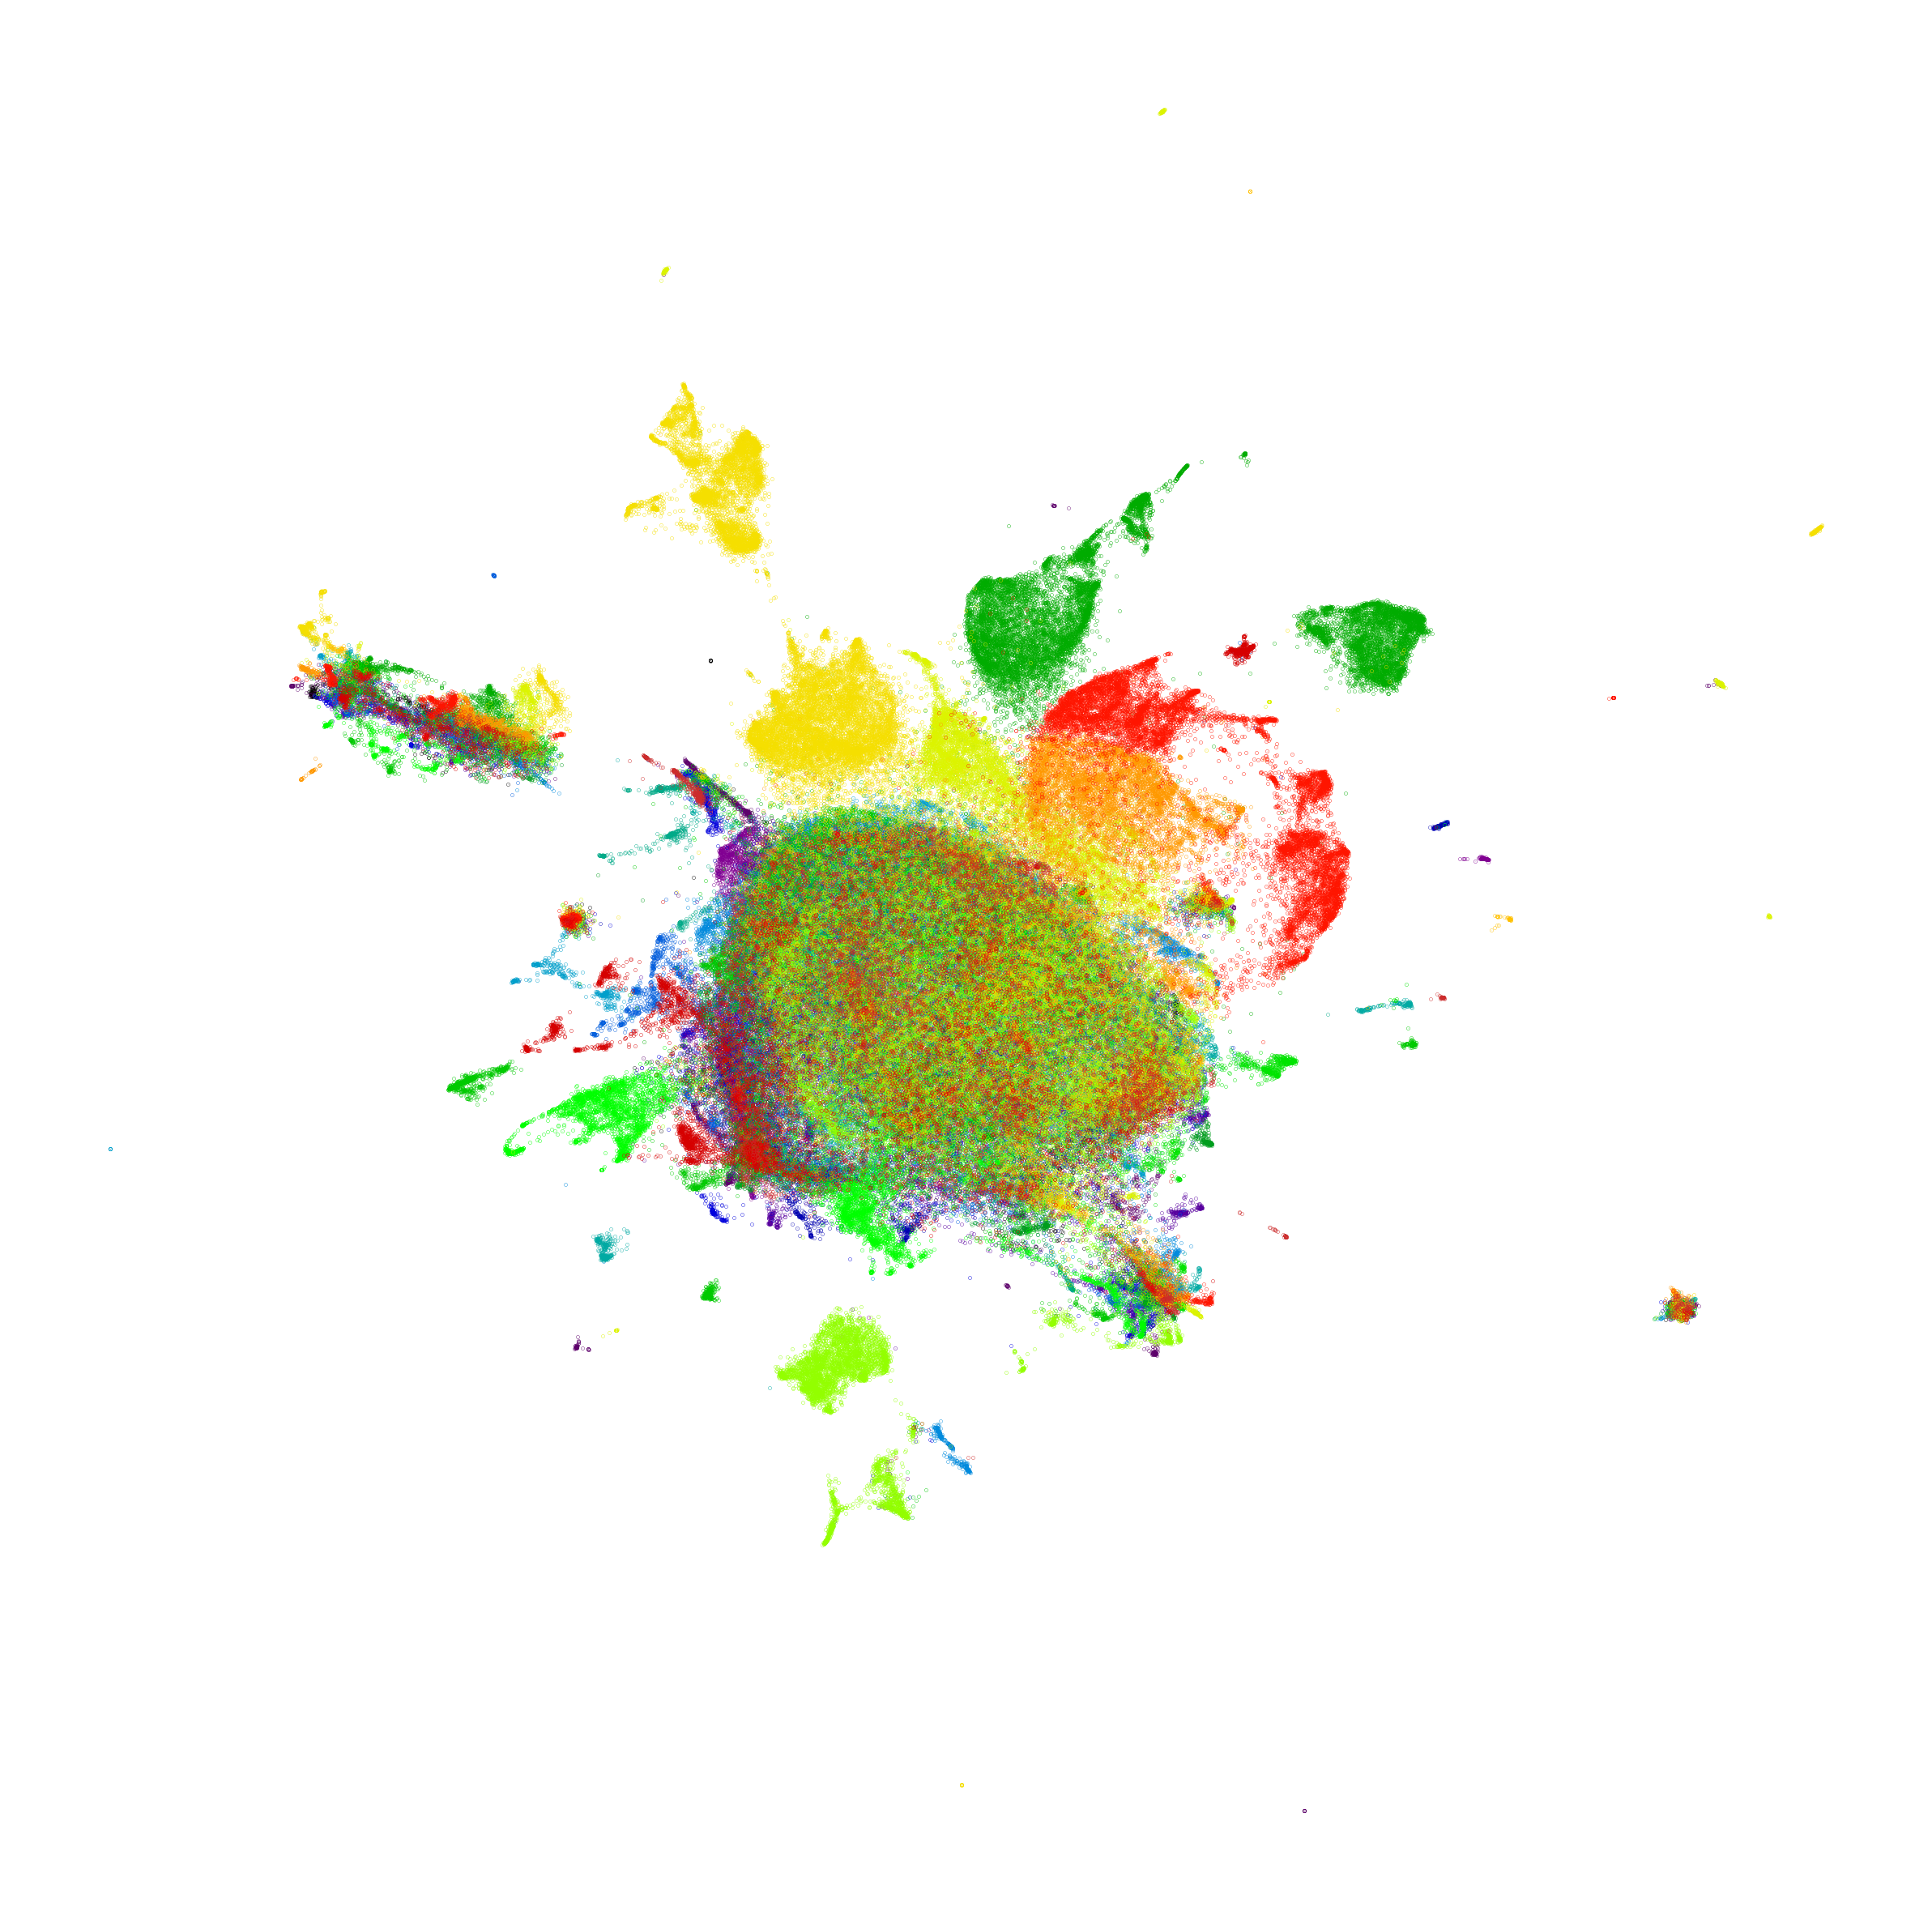

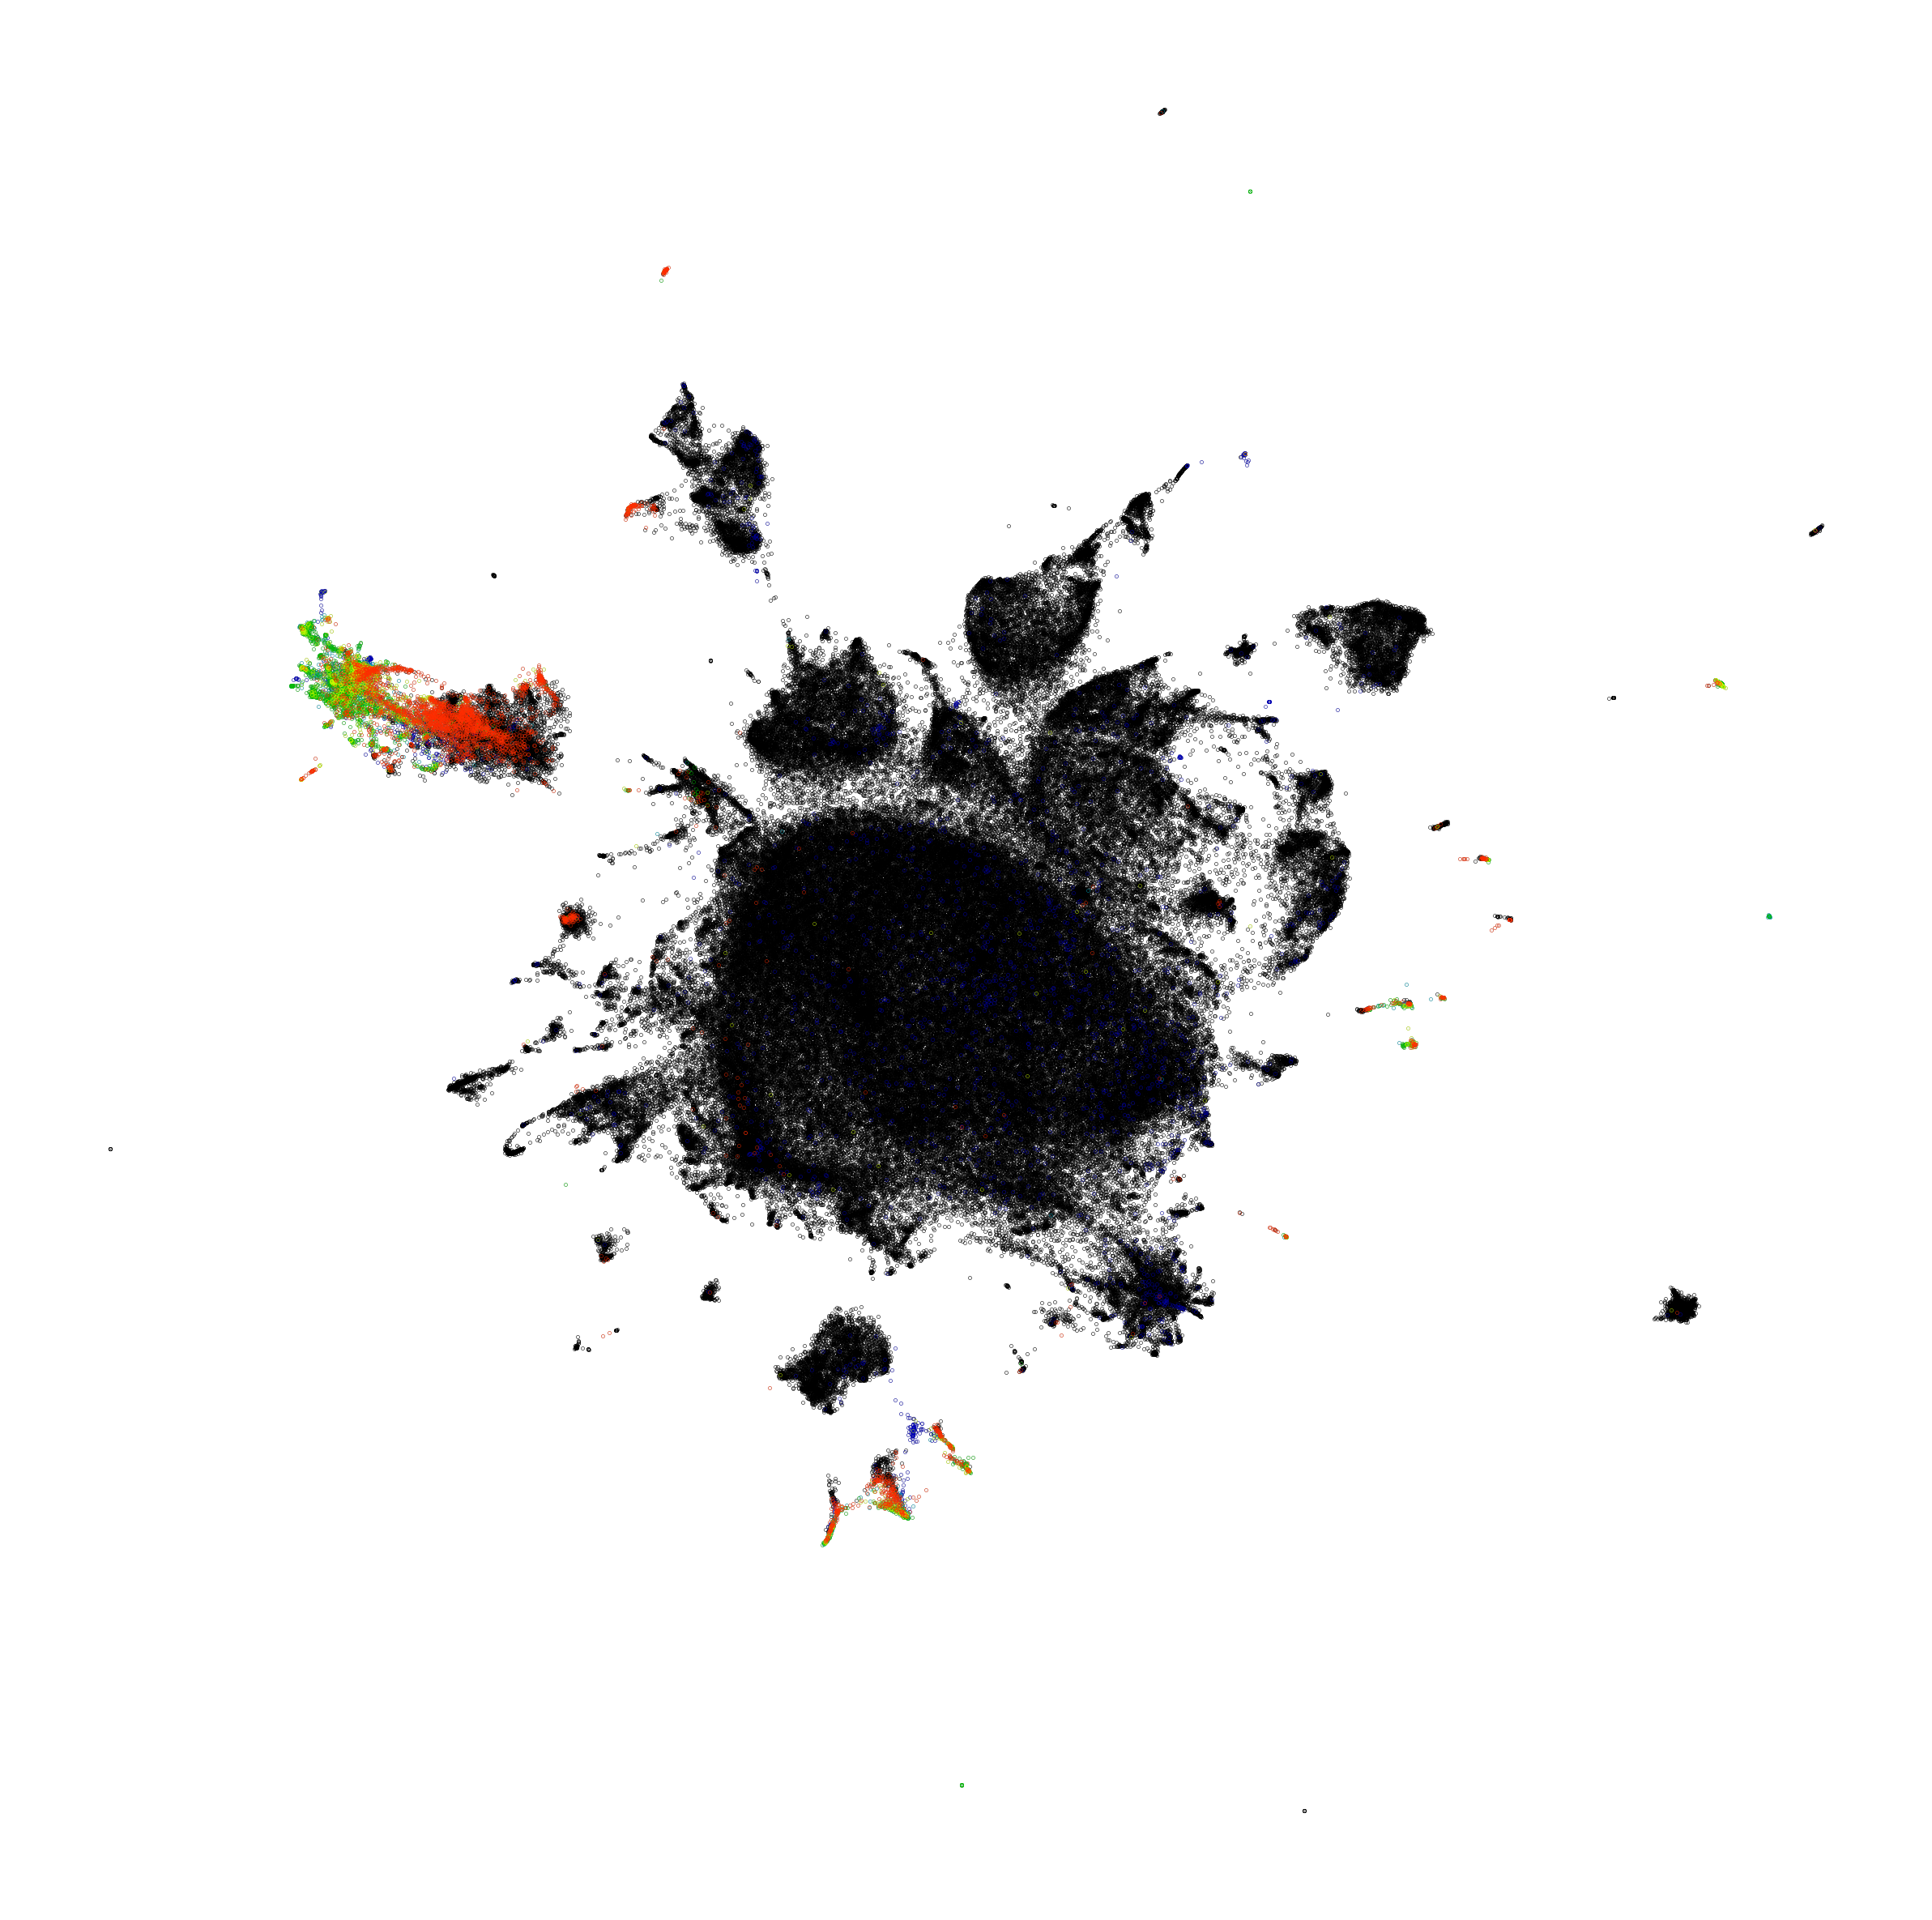

In [7]:
phases = ['Interphase', 
'prophase', 
'early prometaphase', 
'prometaphase/metaphase', 
'anaphase/telophase paired',
'anaphase/telophase unpaired', 
]

sorted_df = pd.read_csv('/scr/mdoron/allen/cytodata-hackathon-base/normalized_cell_df.csv')
sorted_trained_features = torch.load('/scr/mdoron/allen/cytodata-hackathon-base/results_3_channels/normalized_features.pth')[0]
cleaned_sorted_trained_embedding = torch.load('/scr/mdoron/Dino4Cells/Allen_3_channel_trained_embedding.pth')
cleaned_sorted_trained_harmonized_features = torch.load('/scr/mdoron/Dino4Cells/Allen_3_channel_trained_embedding_harmonized.pth')

embedding = cleaned_sorted_trained_embedding

structure_mat, structure_labels = get_col_matrix(sorted_df, ['Structure'])
stage_mat, stage_labels = get_col_matrix(sorted_df, ['cell_stage'])

fig, ax = plt.subplots(figsize=(10,10), facecolor='white', dpi=300)
for cell_ind in range(structure_mat.shape[1]):
    cell_indices = np.where(structure_mat[:,cell_ind])
    plt.scatter(embedding[cell_indices, 0],
                embedding[cell_indices, 1],
                s = 0.01,
                color=cmap(cell_ind / structure_mat.shape[1]),
                label=structure_labels[cell_ind]
               )
plt.axis('off') 
plt.savefig('results/WTC11/WTC11_structure_umap.pdf', format='pdf')

fig, ax = plt.subplots(figsize=(10,10), facecolor='white', dpi=300)
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            s = 0.01,
            color='grey'
           )
for stage_ind in range(stage_mat.shape[1]):
    stage_indices = np.where(stage_mat[:,stage_ind])
    plt.scatter(embedding[stage_indices, 0],
                embedding[stage_indices, 1],
                s = 0.01,
                color=cmap(stage_ind / stage_mat.shape[1]),
                label=phases[stage_ind]
               )
plt.axis('off')
plt.savefig('results/WTC11/WTC11_stage_umap.pdf', format='pdf')


embedding = cleaned_sorted_trained_harmonized_features

structure_mat, structure_labels = get_col_matrix(sorted_df, ['Structure'])
stage_mat, stage_labels = get_col_matrix(sorted_df, ['cell_stage'])

fig, ax = plt.subplots(figsize=(10,10), facecolor='white', dpi=300)
for cell_ind in range(structure_mat.shape[1]):
    cell_indices = np.where(structure_mat[:,cell_ind])
    plt.scatter(embedding[cell_indices, 0],
                embedding[cell_indices, 1],
                s = 0.01,
                color=cmap(cell_ind / structure_mat.shape[1])
               )
plt.axis('off')
plt.savefig('results/WTC11/harmonized_WTC11_structure_umap.pdf', format='pdf')

fig, ax = plt.subplots(figsize=(10,10), facecolor='white', dpi=300)
plt.scatter(embedding[:, 0],
            embedding[:, 1],
            s = 0.01,
            color='grey'
           )
for stage_ind in range(stage_mat.shape[1]):
    stage_indices = np.where(stage_mat[:,stage_ind])
    plt.scatter(embedding[stage_indices, 0],
                embedding[stage_indices, 1],
                s = 0.01,
                color=cmap(stage_ind / stage_mat.shape[1])
               )
plt.axis('off')
plt.savefig('results/WTC11/harmonized_WTC11_stage_umap.pdf', format='pdf')


### Plot mutual information

In [5]:
from sklearn.metrics import mutual_info_score

def create_bins(x):
    unique_xs = sorted(np.unique(x))
    bins = [unique_xs[0] - 0.5]
    for ind in range(len(unique_xs) - 1):
        bins.append(unique_xs[ind] + (unique_xs[ind + 1] - unique_xs[ind]) / 2)
    bins = bins + [unique_xs[-1] + 0.5]  
    return bins

def mutual_info(x,y,code_bin, factor_bin):
    c_xy = np.histogram2d(x,y,(code_bin, factor_bin))[0]
    mi = 0
    N = np.sum(c_xy)
    for i in range(c_xy.shape[0]):
        for j in range(c_xy.shape[1]):
            p_i = np.sum(c_xy[i,:]) / N
            p_j = np.sum(c_xy[:,j]) / N
            p_ij = c_xy[i,j] / N
            if p_ij == 0: 
                mi += 0 
            else:
                mi += (p_ij) * np.log(p_ij / (p_i * p_j))
    return mi

def conditional_mutual_info(x,y,z,bins):
    c_xyz = np.histogramdd((x, 
                          y, 
                          z),
                          bins)[0]
    N = np.sum(c_xyz)
    mi = 0
    p_z = c_xyz.sum(axis=(0,1)) / N
    p_iz = c_xyz.sum(axis=(1)) / N
    p_jz = c_xyz.sum(axis=(0)) / N
    p_ijzs = c_xyz / N
    N = np.sum(c_xyz)
    for i in (range(c_xyz.shape[0])):
        for j in range(c_xyz.shape[1]):
            for z in range(c_xyz.shape[2]):
                if p_ijzs[i,j,z] == 0: 
                    mi += 0 
                else:
                    mi += (p_ijzs[i,j,z]) * np.log((p_z[z] * p_ijzs[i,j,z]) / (p_iz[i,z] * p_jz[j,z]))
    return mi    


def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

In [19]:
config_files = [
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_engineered.yaml',
#     '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_pretrained_combined.yaml',
               ]
labels = [
    'Trained DINO',
    'Trained DINO,\nharmonized',
    'Engineered features',
#     'DINO pretrained',
             ]
allen_model_labels = labels
allen_factor_labels = ['Protein structure', 'Cell stage', 'Well']

config = yaml.safe_load(open(config_files[0], "r"))
df = pd.read_csv(config['embedding']['df_path'])
try:
    features, _, IDs = torch.load(config['embedding']['output_path'])            
except:
    features, IDs = torch.load(config['embedding']['output_path'])            
      
factor_gaps_per_method = []
allen_mi_matrices = []
allen_model_labels = labels
code_bins = [6]
factor_bins = [6]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        try:
            features, _, IDs = torch.load(config['embedding']['output_path'])            
        except:
            features, IDs = torch.load(config['embedding']['output_path'])            
#         pca = decomposition.PCA(n_components=100)
#         reduced_features = pca.fit_transform(features)
        reduced_features = features
    
        if 'harmonized' in label:
            reduced_features = harmonize(torch.Tensor(reduced_features).numpy(), 
                                            df,
                                            batch_key = ['Structure'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
            

        well_mat, well_labels = get_col_matrix(df, ['WellId'])    
        structure_mat, structure_labels = get_col_matrix(df, ['Structure'])    
        stage_mat, stage_labels = get_col_matrix(df, ['cell_stage'])    
        factors = np.stack((np.argmax(structure_mat, axis=1),
                        np.argmax(stage_mat, axis=1),
                        np.argmax(well_mat, axis=1))).T
        codes = torch.Tensor(reduced_features)

        allen_protein_MI = []
        allen_cell_MI = []
        allen_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            allen_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            allen_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            allen_well_MI.append(well_mi)      
        mi_matrix = np.stack((allen_protein_MI, allen_cell_MI, allen_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        allen_mi_matrices.append(mi_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:18<00:00, 40.79it/s]


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 64.93it/s]


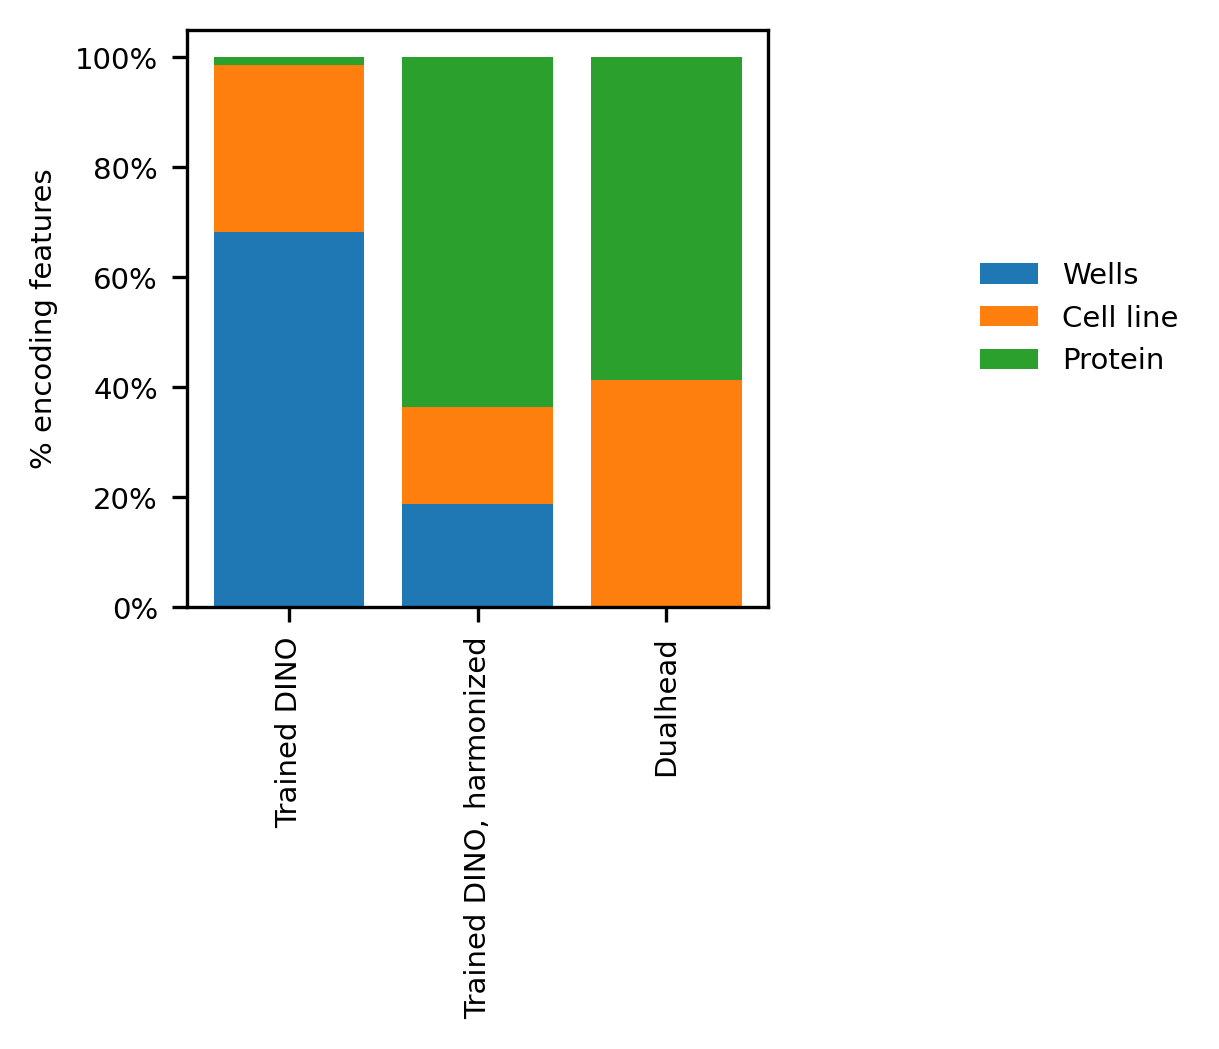

In [22]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(allen_mi_matrices, allen_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_cell) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
dominant_fov_percentages = dominant_fov_percentages[:,np.argsort(dominant_fov_percentages[0,:])[::-1]]

import matplotlib.gridspec as gridspec
import matplotlib
font = {'size'   : 7}
matplotlib.rc('font', **font)

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)

plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Wells',
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Cell line',
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:2].sum(axis=1),
    height = dominant_fov_percentages[:,2],
    label='Protein'
       )
plt.legend(bbox_to_anchor=(1.75,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(single_model_labels)),single_model_labels, rotation=90)

plt.savefig('results/WTC11/WTC11_mutual_information.pdf', format='pdf')

### Plot classification results

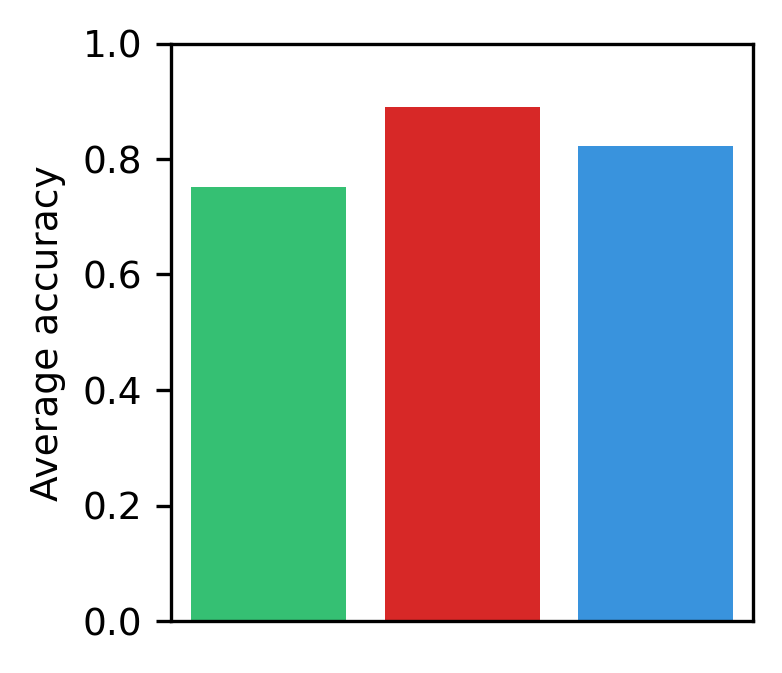

In [11]:
DINO_train = 0.823
DINO_pretrained = 0.89
XGBoost = 0.751 

fig, axis = plt.subplots(1,1,figsize=(2.5,2.5), dpi=300)
plt.bar(x=[0], height=[XGBoost], color='#35c073')
plt.bar(x=[1], height=[DINO_pretrained], color='#d72827')
plt.bar(x=[2], height=[DINO_train], color='#3993dd')
plt.ylabel('Average accuracy')
plt.xticks([])
plt.axis([-0.5, 2.5, 0, 1])
plt.savefig('results/WTC11/WTC11_Cell_Cycle.pdf')

<Figure size 300x300 with 0 Axes>

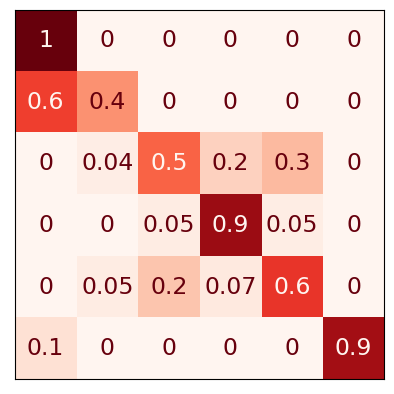

<Figure size 300x300 with 0 Axes>

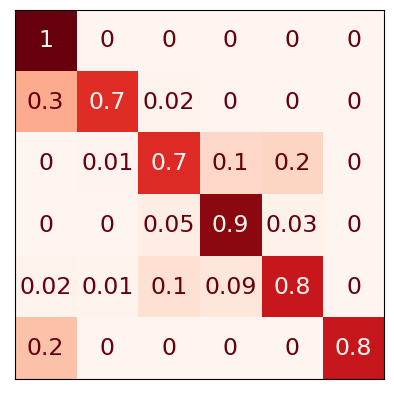

<Figure size 300x300 with 0 Axes>

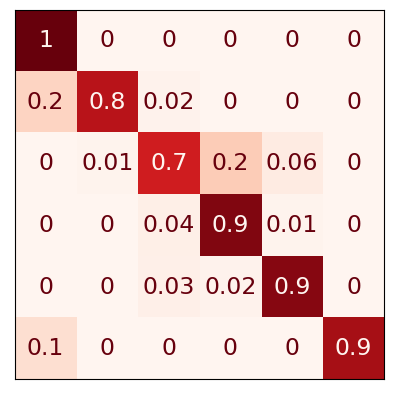

In [24]:
for model_name in ['Allen_xgb_model','Allen_trained_model','Allen_pretrained_model']:
    all_targets, predictions, = torch.load(f'WTC11_data/{model_name}.pth')
    try:
        mat = confusion_matrix(predictions, all_targets, normalize='true')
    except:
        mat = confusion_matrix(np.argmax(predictions, axis=1), np.argmax(all_targets, axis=1), normalize='true')
    rounded_mat = np.copy(mat)
    rounded_mat[np.where(rounded_mat < 0.01)[0], 
                np.where(rounded_mat < 0.01)[1]] = 0
    fig = plt.figure(figsize=(1,1), dpi=300)
    c = ConfusionMatrixDisplay(confusion_matrix=rounded_mat, display_labels=phases)
    c.plot(cmap='Reds', text_kw={'fontsize' : 17}, values_format='.1g', colorbar=False)
    axes = c.ax_
    axes.set_yticks([])
    axes.set_yticks([])
    axes.set_yticklabels([])
    axes.set_xticks([])
    axes.set_xlabel('')
    axes.set_ylabel('')


### Pseudotime

In [46]:
sorted_df = pd.read_csv('/scr/mdoron/allen/cytodata-hackathon-base/normalized_cell_df.csv')
features_g = torch.load('/scr/mdoron/allen/cytodata-hackathon-base/results/pretrained_g_features.pth')
features_b = torch.load('/scr/mdoron/allen/cytodata-hackathon-base/results/pretrained_b_features.pth')
features_y = torch.load('/scr/mdoron/allen/cytodata-hackathon-base/results/pretrained_y_features.pth')
sorted_trained_features = torch.concat([
             features_g[0],
             features_b[0],
             features_y[0],
                 ], axis=1)
sorted_trained_features[np.unique(np.where(np.isnan(sorted_trained_features.numpy()))[0])] = 0   


0.685056039063025
Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


/scr/mdoron/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_2357203/160950970.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2.5, 2.5), dpi=300)


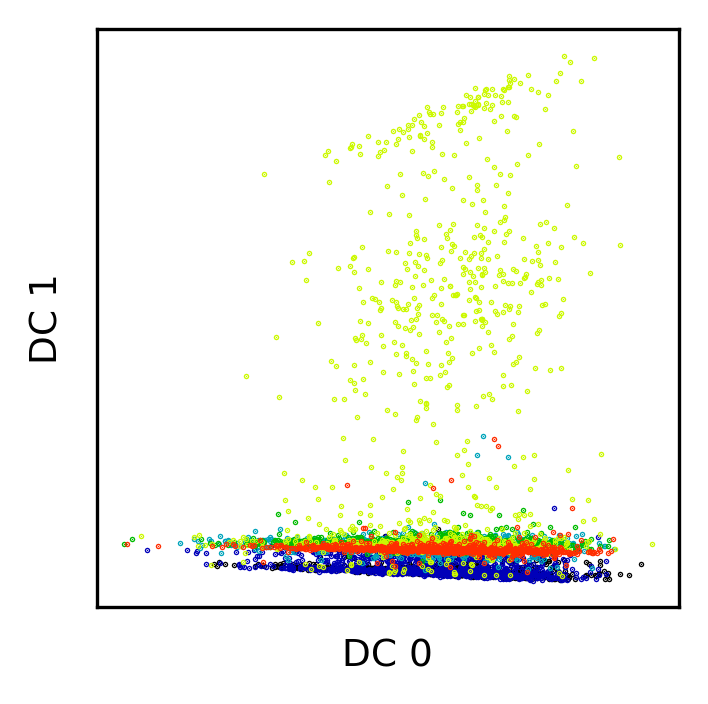

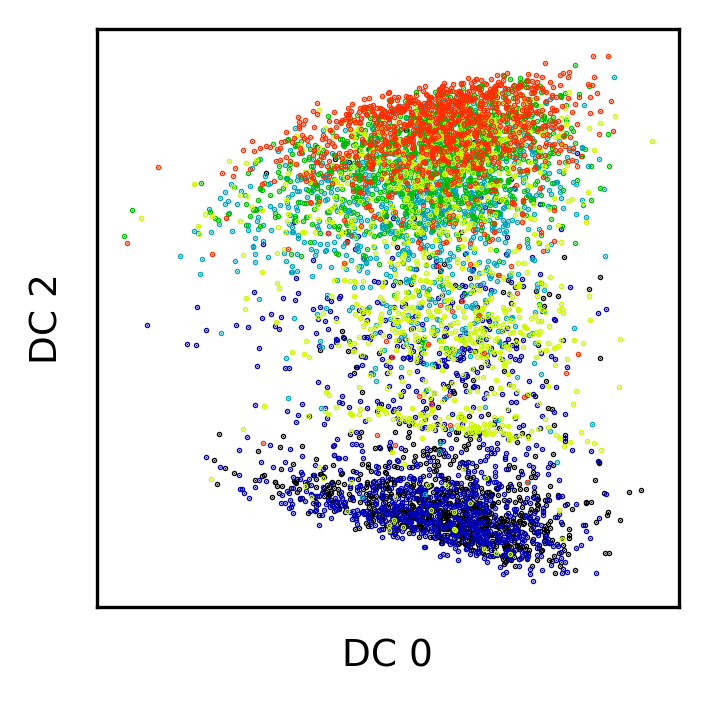

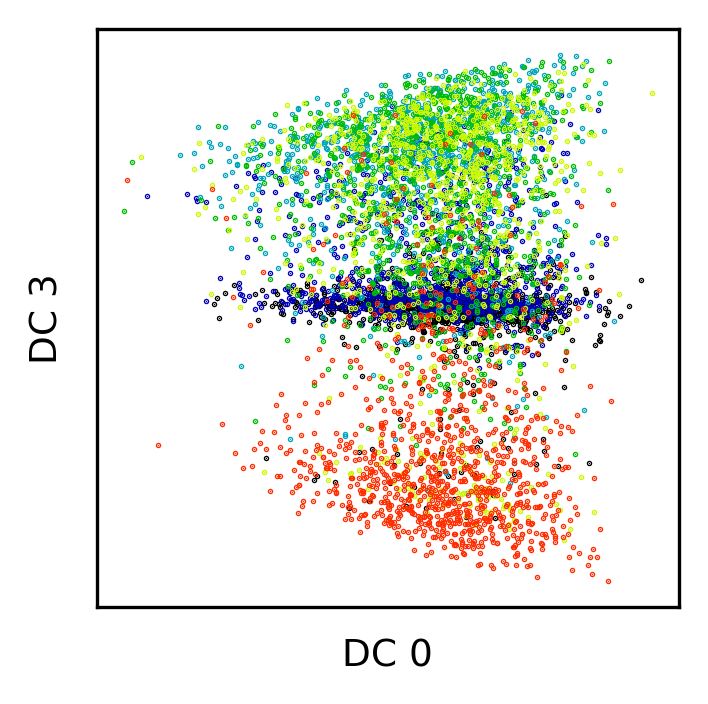

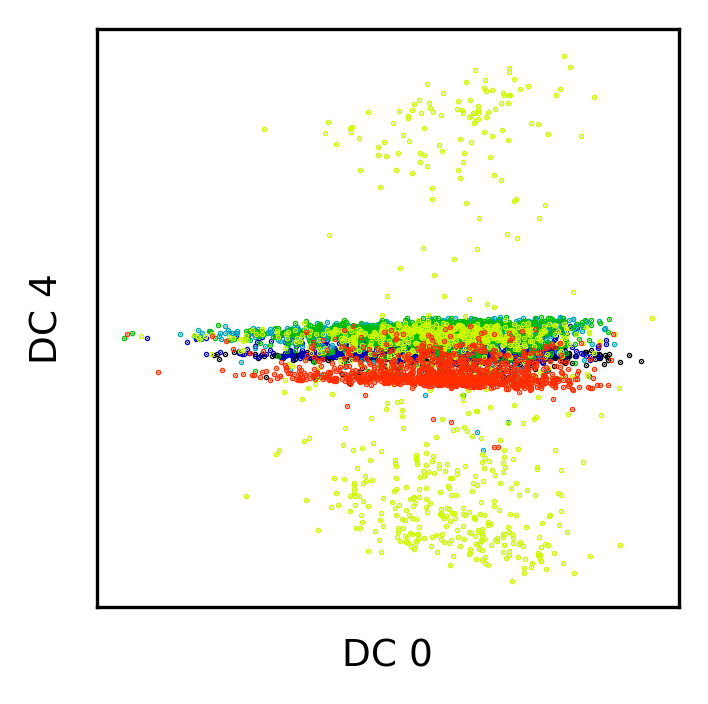

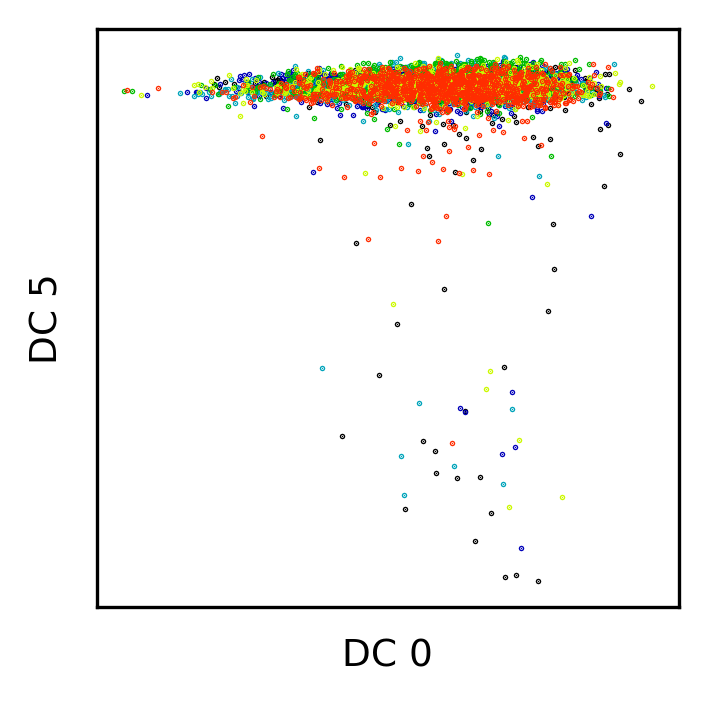

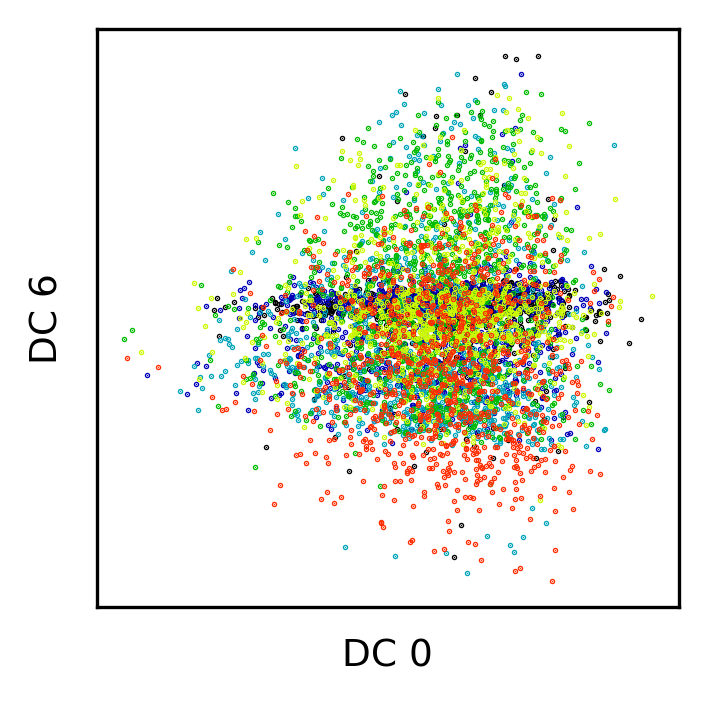

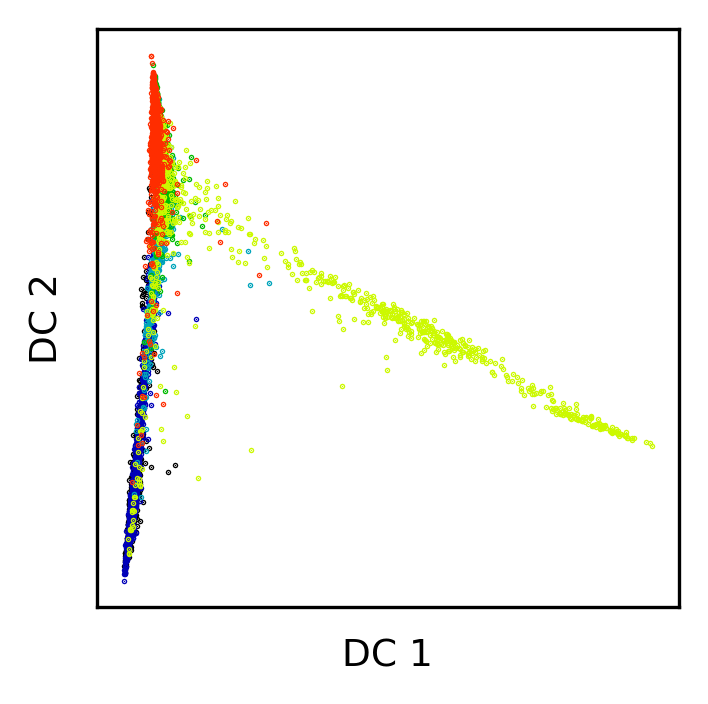

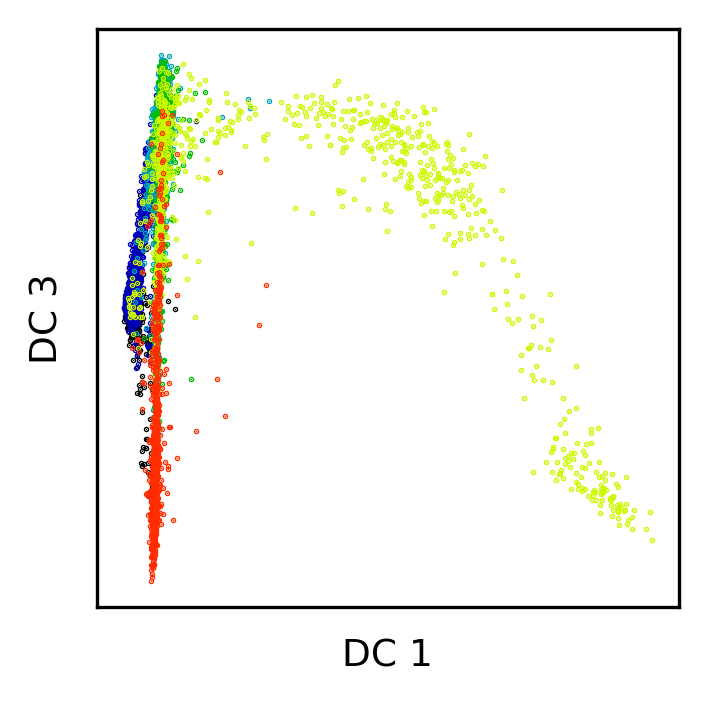

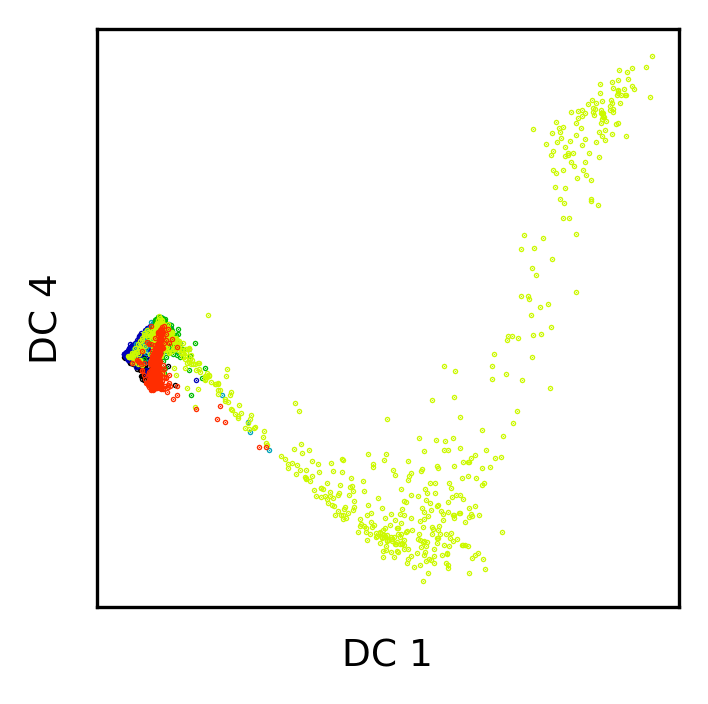

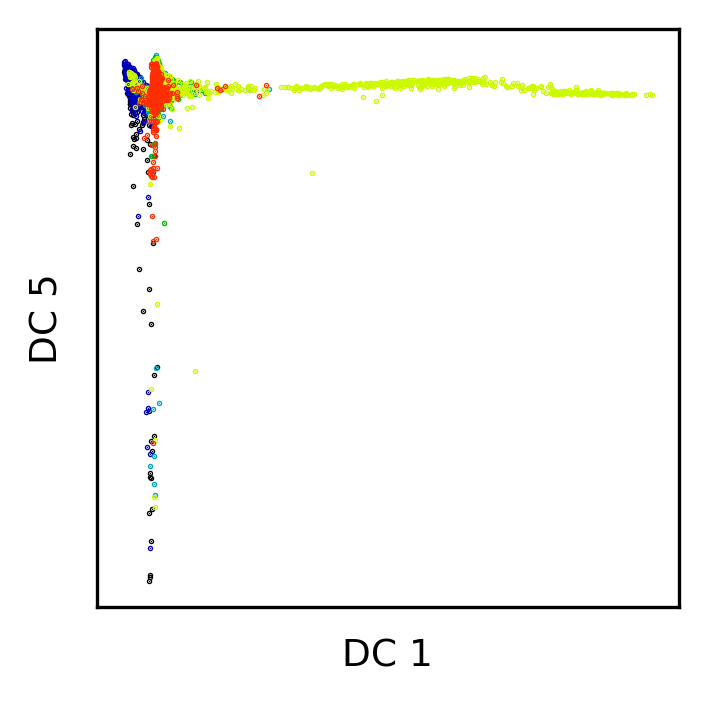

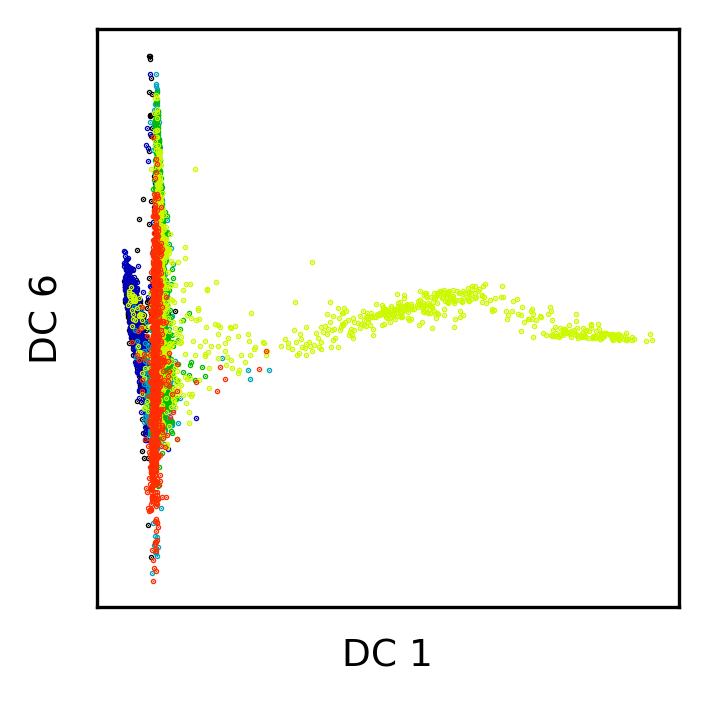

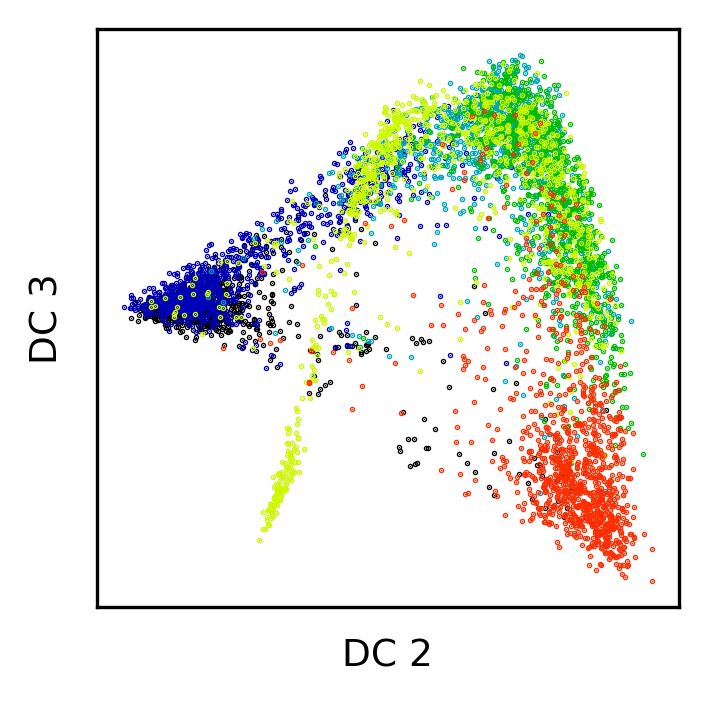

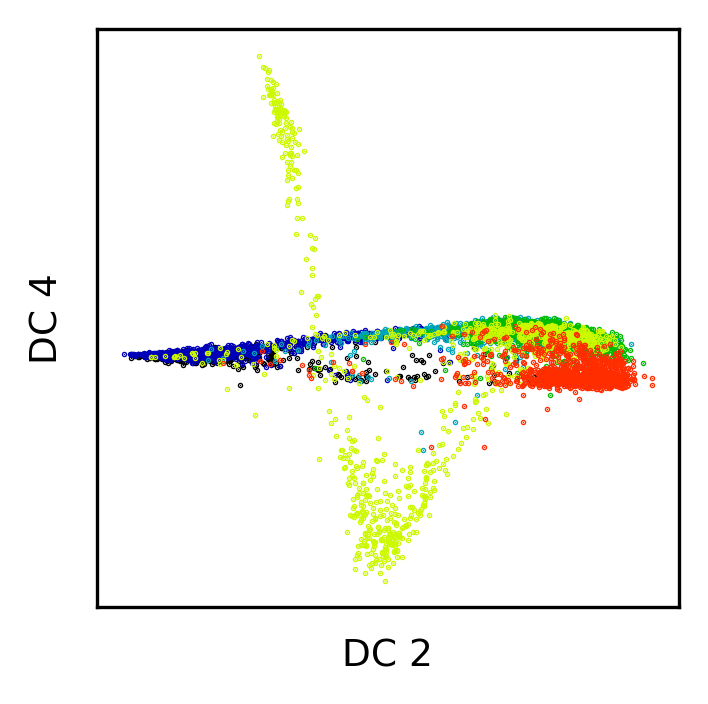

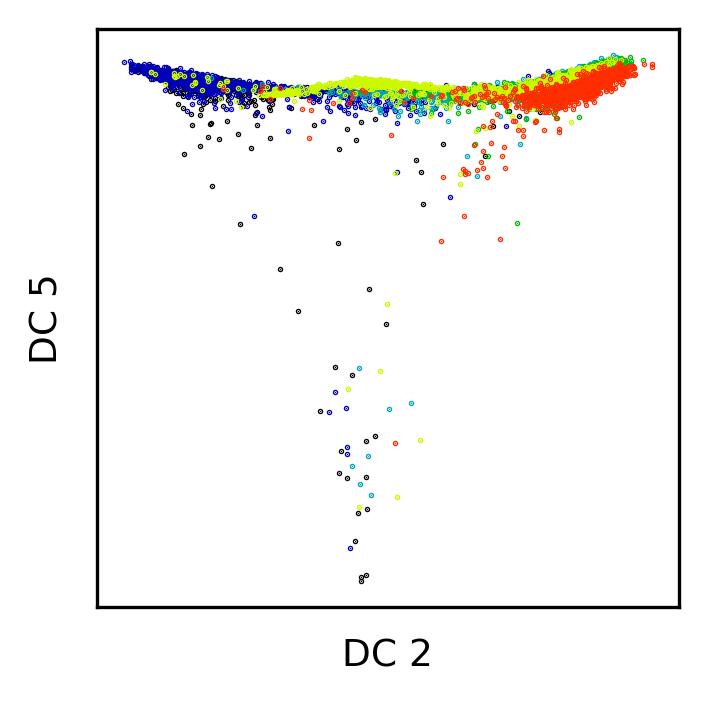

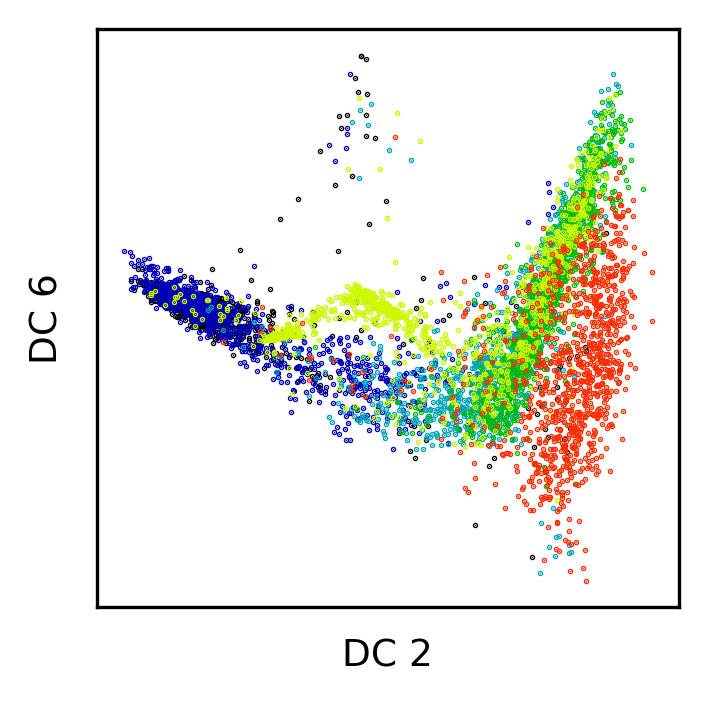

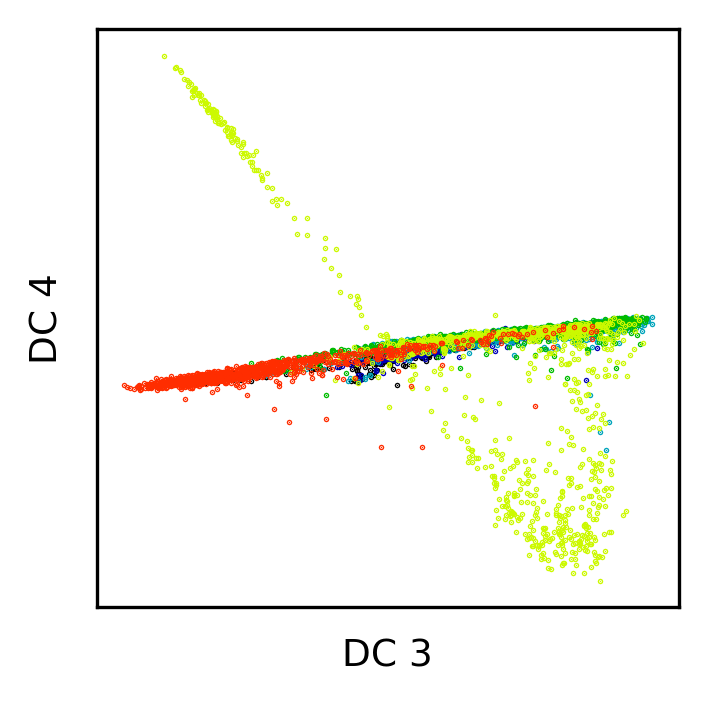

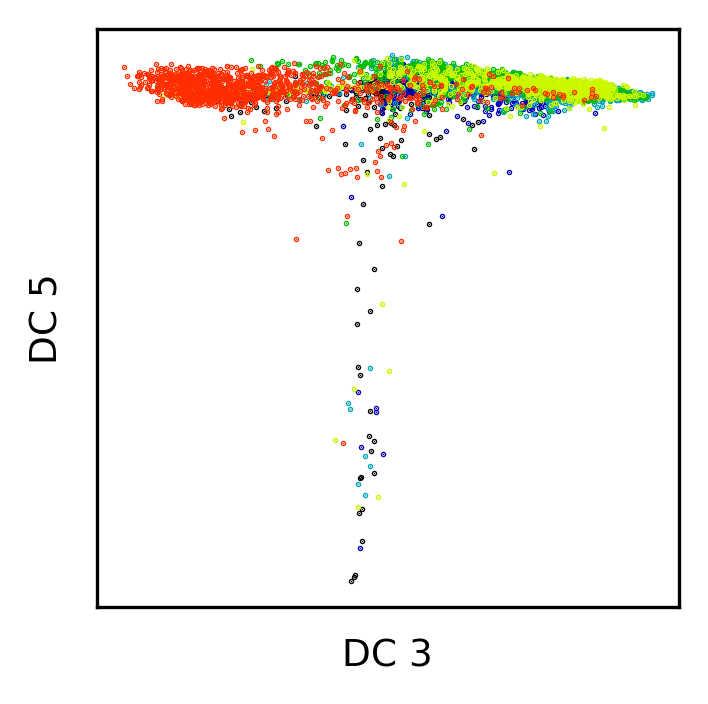

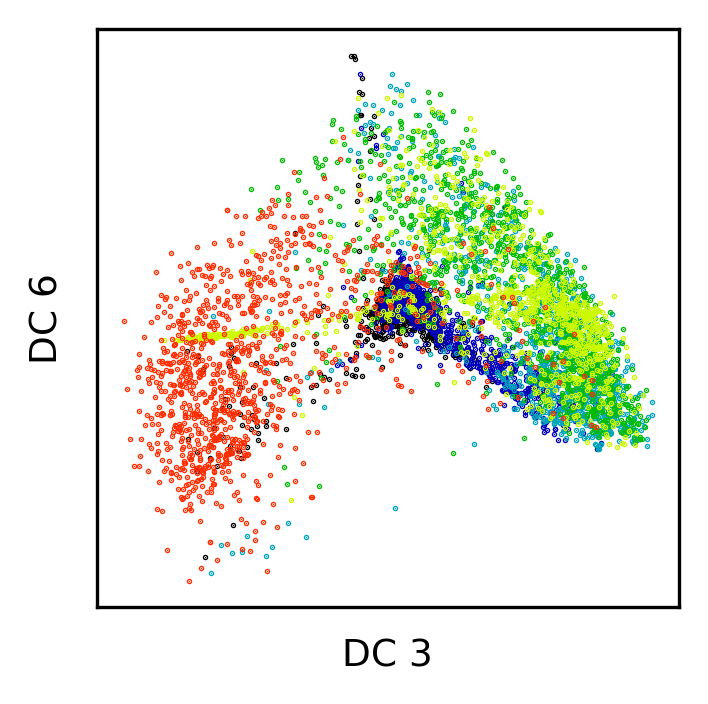

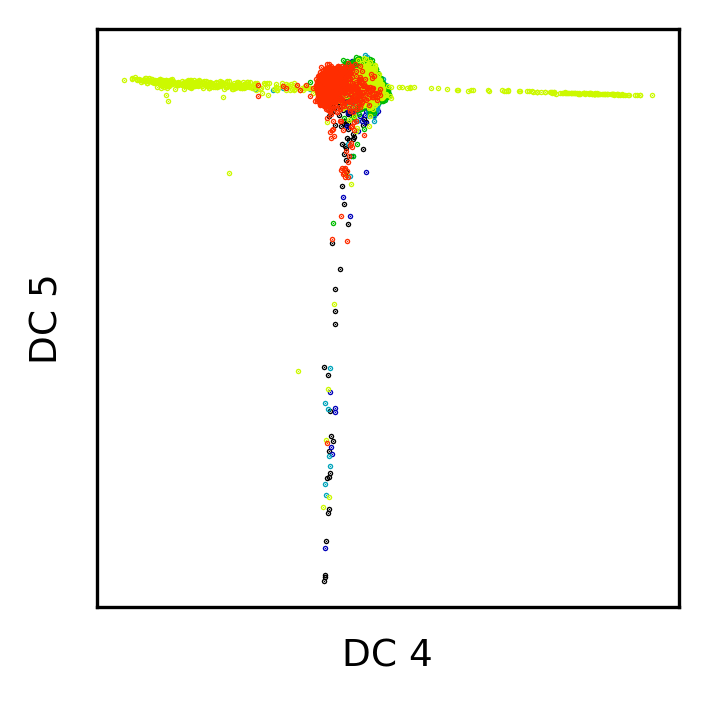

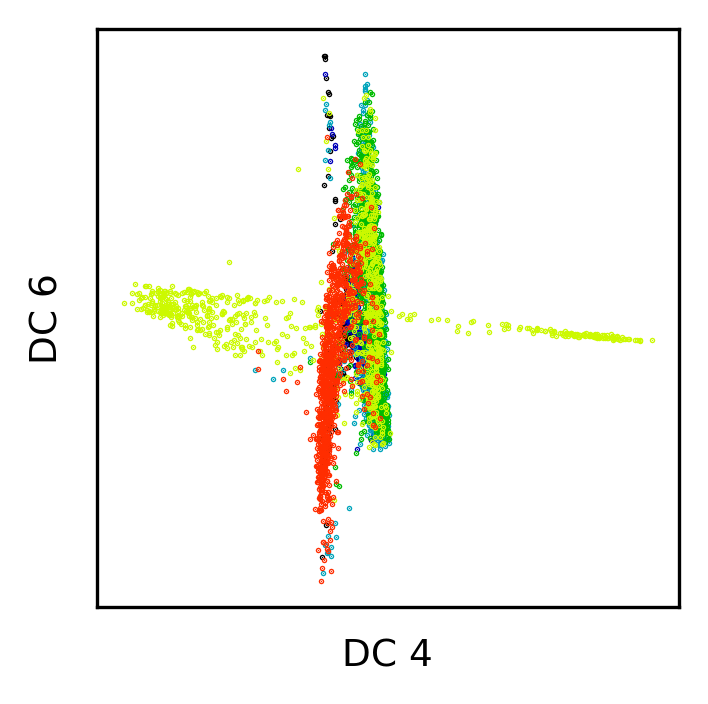

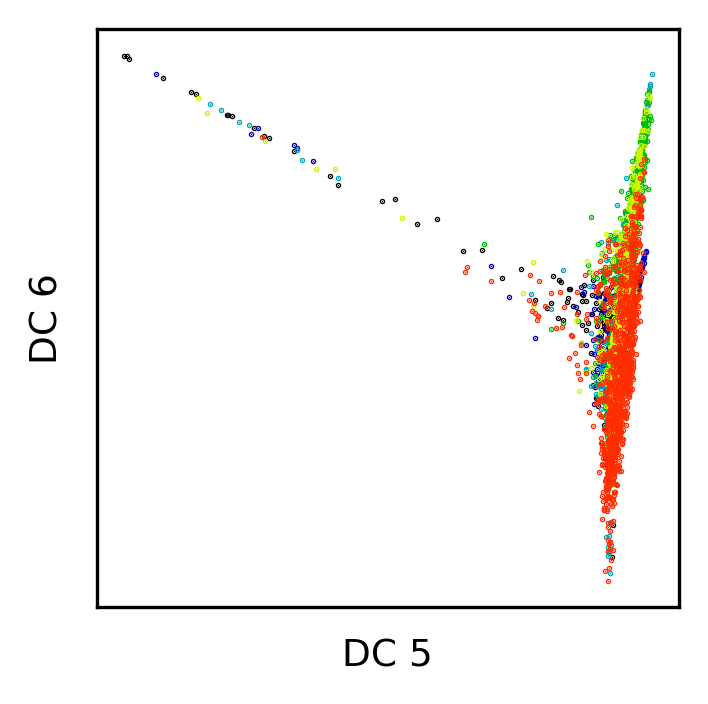

In [47]:
n_components = 50
samples_per_cell_stage = 1000
sorted_df['cell_stage'] = sorted_df['cell_stage'].map(dict(zip(sorted(sorted_df['cell_stage'].unique()), phases)))

cell_stage_groups = sorted_df.reset_index().groupby(['cell_stage']).groups
balanced_indices = np.concatenate([(cell_stage_groups[key][:samples_per_cell_stage]) for key in cell_stage_groups])
reduced_features = get_reduced_features(sorted_trained_features[balanced_indices], n_components=n_components)
sorted_df =  sorted_df.iloc[balanced_indices].reset_index()
harmonized_features = get_harmonized_features(reduced_features, sorted_df, ['Structure'])

features_to_analyse = torch.Tensor(harmonized_features).numpy()
adata = sc.AnnData(features_to_analyse, obs=sorted_df[['CellId','Structure','cell_stage']], 
                   var=[f'feature_{i}' for i in range(features_to_analyse.shape[1])])
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_stage'] == 'Interphase')[0]
neighbors = sc.pp.neighbors(adata, use_rep='X')
sc.tl.diffmap(adata, n_comps=10)
neighbors = sc.pp.neighbors(adata, use_rep='X', copy=True)
sc.tl.dpt(adata)
pseudo_time = adata.obs['dpt_pseudotime'].values

transition_matrix = neighbors.obsp['connectivities']
eig_val, eig_vec = eigs(transition_matrix, k=10)

cell_stage_groups = sorted_df.reset_index().groupby(['cell_stage']).groups
pseudo_time_divided_by_cell_stages = [(pseudo_time)[cell_stage_groups[k]] for k in sorted(cell_stage_groups.keys())]
no_inf_pseudo_time = np.where(pseudo_time == np.inf, np.nan, pseudo_time)
mean_pseudotime = [np.nanmean(no_inf_pseudo_time[cell_stage_groups[k]]) for k in sorted(cell_stage_groups.keys())]
std_pseudotime = [np.nanstd(no_inf_pseudo_time[cell_stage_groups[k]]) for k in sorted(cell_stage_groups.keys())]

cell_stage_groups = sorted_df.groupby('cell_stage').groups
for i in range(7):
    for j in range(i + 1, 7):
        plt.figure(figsize=(2.5, 2.5), dpi=300)
        for ind, key in enumerate(phases):
            indices = cell_stage_groups[key]
            plt.scatter(adata.obsm['X_diffmap'][indices,i],
                        adata.obsm['X_diffmap'][indices,j], 
                        s=0.1,
                        color=cmap(ind / len(phases)))
            plt.xlabel(f'DC {i}')
            plt.ylabel(f'DC {j}')
            plt.xticks([])
            plt.yticks([])
        plt.savefig(f'results/WTC11/WTC11_pseudotime_{i}_{j}.pdf', format='pdf')


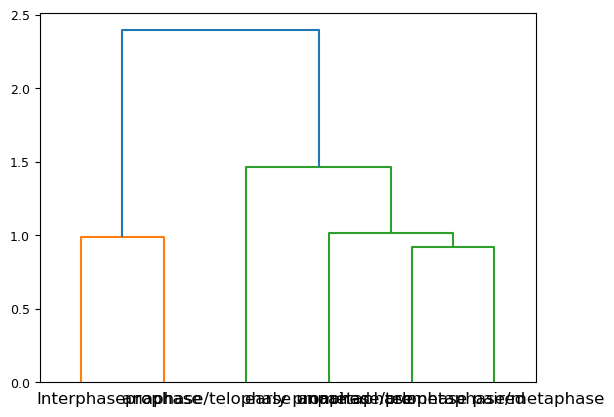

<Figure size 640x480 with 0 Axes>

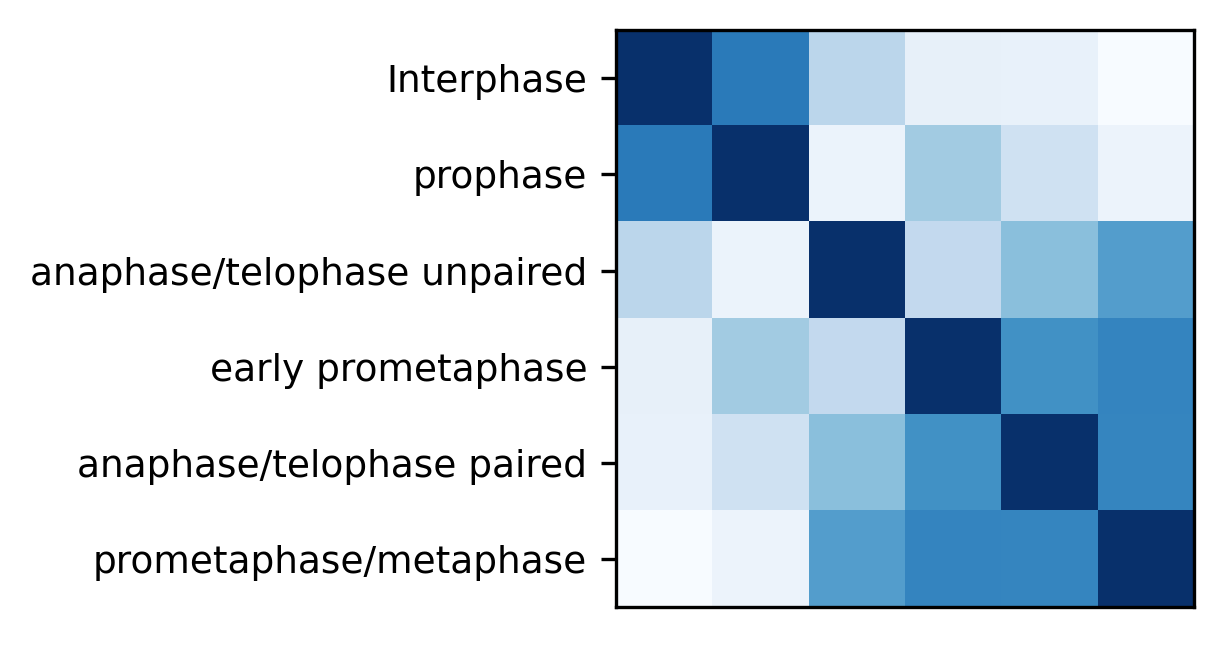

In [51]:
scaled_averaged_features, cell_columns = get_averaged_features(sorted_df, torch.Tensor(reduced_features), ['cell_stage'], sort=True)

reduced_averaged_features = 1 - squareform(pdist(scaled_averaged_features, metric='cosine'))
plt.figure()
ground_truth_Z = linkage(reduced_averaged_features)
dn = dendrogram(ground_truth_Z, labels = cell_columns)
reduced_averaged_features = reduced_averaged_features[dn['leaves'], :][:, dn['leaves']]

cell_columns = dn['ivl']
plt.figure()
plt.figure(figsize=(2.5,2.5), dpi=300)
plt.imshow(reduced_averaged_features, cmap='Blues')
plt.xticks([])
plt.yticks(range(len(cell_columns)), cell_columns)
print('')
plt.savefig('results/WTC11/WTC11_Cell_stage_similarity.pdf', format='pdf')


### Analysing key descriptors

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24it/s]


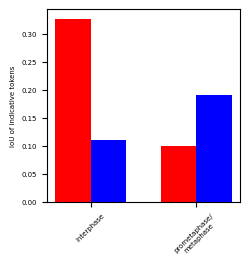

In [4]:
from sklearn.decomposition import PCA
import cv2
from matplotlib.colors import LinearSegmentedColormap
from skimage import io
from typing import Union, List, Tuple
from PIL import Image
from pathlib import Path
from torchvision import transforms
from utils.augmentations import Single_cell_Resize, Single_cell_centered, self_normalize
import utils.vision_transformer as vits
from utils.extractor import ViTExtractor
from skimage.filters import threshold_otsu
from scipy.spatial.distance import pdist, cdist
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict_group(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        incorrect_indices = np.where(np.ptp(votes, axis=1) > 0)
        zero_indices = np.where(votes[:,0] == 0)[0]
        one_indices = np.where(votes[:,0] == 1)[0]
        result = np.zeros(len(votes))
        result[one_indices] = 1
        result[zero_indices] = 0
        result[incorrect_indices] = np.nan
        return result
    
    def predict_cell(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        correct_cell = np.max(((votes[:, 1:] - votes[:,[0]]) == 0) == True, axis=1)
        return correct_cell

def preprocess(
    image_path: Union[str, Path],
    load_size: Union[int, Tuple[int, int]] = None,
) -> Tuple[torch.Tensor, Image.Image]:
    img = io.imread(image_path).transpose(1,2,0).astype(float)
    img = (img * 255).astype(np.uint8)
    pil_image = img
    if load_size is not None:
        pil_image = transforms.Resize(
            load_size, interpolation=transforms.InterpolationMode.LANCZOS
        )(pil_image.astype(float))
    prep = transforms.Compose(
        [
            transforms.ToTensor(),
            self_normalize(),
        ]
    )
    prep_img = prep(pil_image[:,:,[1,2,3]])[None, ...]
    return prep_img, pil_image

model = vits.__dict__['vit_base'](
    img_size=[224],
    patch_size=8,
    drop_path_rate=0.1,  # stochastic depth
    in_chans=3,
)
state_dict = torch.load('/scr/mdoron/allen/cytodata-hackathon-base/models_3_channels/checkpoint.pth')
teacher = state_dict
if "teacher" in state_dict.keys():
    teacher = state_dict["teacher"]
teacher = {k.replace("module.", ""): v for k, v in teacher.items()}
teacher = {k.replace("backbone.", ""): v for k, v in teacher.items()}
model.load_state_dict(teacher, strict=False)

extractor = ViTExtractor(
    model_type='dino_vits8',
    model=model,
    stride=4,
    device='cuda',
    load_size=224,
)

df = pd.read_csv('/scr/mdoron/allen/cytodata-hackathon-base/normalized_cell_df.csv')
condition_1 = df[df.cell_stage.isin(['M0']) & df.Structure.isin(['mitochondria'])].sample(frac=1)
condition_2 = df[df.cell_stage.isin(['M4M5']) & df.Structure.isin(['mitochondria'])].sample(frac=1)

num_cells_per_group = 50
small_df = pd.concat((
    condition_1.iloc[:num_cells_per_group],
    condition_2.iloc[:num_cells_per_group],
          ))

images_paths = small_df.file.values
all_descriptors = []
all_descriptors_clean = []
all_images = []
all_features = []
for path in tqdm(images_paths):
    image_batch, image_pil = preprocess(path)  
    image_pil = io.imread(path.replace('normalized_cell_data','cell_data'))
    descs = extractor.extract_descriptors(image_batch.to('cuda')).detach().cpu().numpy()[0,0,:,:]
    cell_mask = (image_pil[5,:,:]).astype(bool)
    cell_mask = (cv2.resize(cell_mask.astype(float), dsize=(92, 58), interpolation=cv2.INTER_CUBIC) > 0.5)    
    descs = extractor.extract_descriptors(image_batch.to('cuda')).detach().cpu().numpy()[0,0,:,:]
    all_descriptors_clean.append(np.copy(descs))
    descs[cell_mask.flatten() == False,:] = 0
    all_descriptors.append(descs)
    all_images.append(np.array(image_pil))
    all_features.append(model(image_batch.to('cuda')).detach().cpu().numpy())
all_descriptors = np.stack(all_descriptors)
all_descriptors_clean = np.stack(all_descriptors_clean)
all_images = np.stack(all_images)


group_IDs = np.array([[0] * 5336 for i in range(num_cells_per_group)] + [[1] * 5336 for i in range(num_cells_per_group)]).flatten()
cell_IDs = np.array([[[j] * 5336] for j in range(num_cells_per_group * 2)]).flatten()
n_components = 10
pca = PCA(n_components=n_components, whiten=True)
pca_descs = pca.fit_transform(np.concatenate(all_descriptors))
pca_descs_clean = pca.fit_transform(np.concatenate(all_descriptors_clean))
individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)
individual_pca_descs_clean = pca_descs_clean.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)

group_fknn = FaissKNeighbors(k=5)
queries = pca_descs[:,:4]
group_fknn.fit(queries, group_IDs)
predictions = group_fknn.predict_group(queries)
robust_group_descriptor_indices_0 = np.where(predictions == 0)[0]
robust_group_descriptor_indices_1 = np.where(predictions == 1)[0]

cell_fknn = FaissKNeighbors(k=2)
cell_fknn.fit(queries, cell_IDs)
predictions = cell_fknn.predict_cell(queries)
robust_cell_descriptor_indices = np.where(predictions)[0]

robust_group_descriptor_indices_0 = np.array(list(set(robust_group_descriptor_indices_0).difference(robust_cell_descriptor_indices)))
robust_group_descriptor_indices_1 = np.array(list(set(robust_group_descriptor_indices_1).difference(robust_cell_descriptor_indices)))
robust_group_descriptor_indices_0 = robust_group_descriptor_indices_0[:len(robust_group_descriptor_indices_1)]
robust_group_descriptor_indices_1 = robust_group_descriptor_indices_1[:len(robust_group_descriptor_indices_0)]

group_1_inds = list(range(num_cells_per_group))
group_2_inds = list(range(len(individual_pca_descs) - num_cells_per_group,len(individual_pca_descs),1))
cytosol_IOUs = []
nucleus_IOUs = []
individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)
informative_descriptors = np.array([np.unravel_index(ind, all_descriptors.shape[:2]) for ind in sorted(robust_group_descriptor_indices_0)[:len(robust_group_descriptor_indices_1)] + sorted(robust_group_descriptor_indices_1)[:len(robust_group_descriptor_indices_0)]])

for ind in range(len(individual_pca_descs)):
    informative_inds = informative_descriptors[np.where(informative_descriptors[:,0] == ind)[0], 1]
    mask = np.zeros((58, 92))
    masked_indices = np.array([np.unravel_index(ind, mask.shape) for ind in sorted(informative_inds)])
    mask.flat[informative_inds] = 1
    mask = (cv2.resize(mask, dsize=(374, 238), interpolation=cv2.INTER_CUBIC) > 0.5)
    
    image_pil = all_images[ind]
    nucleus = image_pil[4,:,:].astype(bool)
    cytosol = (image_pil[5,:,:] - image_pil[4,:,:]).astype(bool)
    mask = mask * image_pil[5,:,:]

    overlap = nucleus * mask # Logical AND
    union = nucleus + mask # Logical OR
    nucleus_IOU = overlap.sum()/float(union.sum())
    nucleus_IOUs.append(nucleus_IOU)
    
    overlap = cytosol * mask # Logical AND
    union = cytosol + mask # Logical OR
    cytosol_IOU = overlap.sum()/float(union.sum())
    cytosol_IOUs.append(cytosol_IOU)
group_1_cytosol_IOUs = np.array(cytosol_IOUs)[group_1_inds]
group_1_nucleus_IOUs = np.array(nucleus_IOUs)[group_1_inds]

group_2_cytosol_IOUs = np.array(cytosol_IOUs)[group_2_inds]
group_2_nucleus_IOUs = np.array(nucleus_IOUs)[group_2_inds]

import matplotlib.ticker as mtick

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(x=[0], 
        bottom=0,
        height=[
            np.mean(group_1_nucleus_IOUs),    
        ],
        color='red',
       width=0.5)
plt.bar(x=[0.5], 
        bottom=0,
        height=[
            np.mean(group_1_cytosol_IOUs),    
        ],
        color='blue',
       width=0.5)

plt.bar(x=[1.5], 
        bottom=0,
        height=[
            np.mean(group_2_nucleus_IOUs),    
        ],
        label='Nucleus',
        color='red',
       width=0.5)
plt.bar(x=[2], 
        bottom=0,
        height=[
            np.mean(group_2_cytosol_IOUs),    
        ],
        color='blue',
        label='Cytoplasm',
       width=0.5)

plt.xticks([0.25, 1.75], ['Interphase', 'prometaphase/\nmetaphase'], rotation=45)
plt.ylabel('IoU of indicative tokens')
plt.savefig('results/WTC11/WTC11_ratio.pdf')


0.14617691154422788
0.12218890554722639


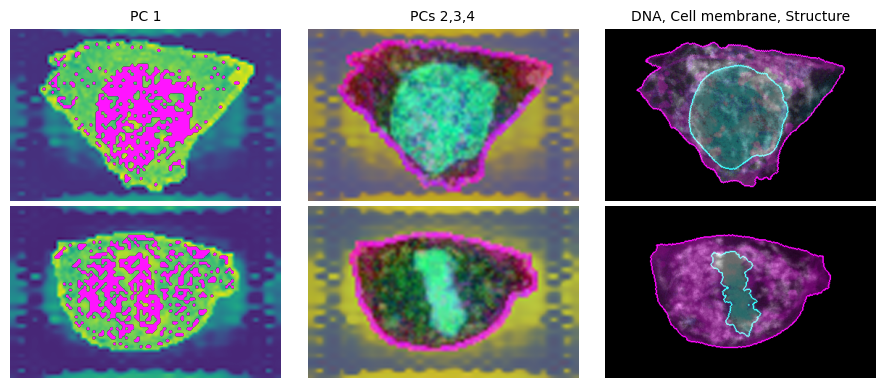

In [17]:
import cv2
import skimage
from matplotlib.colors import LinearSegmentedColormap

magenta_cmap = LinearSegmentedColormap.from_list('magentas', ['#000000','#ff14ff'], N=256)
cyan_cmap = LinearSegmentedColormap.from_list('cyans', ['#000000','#00ffff'], N=256)
white_cmap = LinearSegmentedColormap.from_list('whites', ['#7a7a7a','#ffffff'], N=256)

individual_pca_descs = pca_descs.reshape(all_descriptors.shape[0], all_descriptors.shape[1], n_components)
individual_pca_descs_clean = pca_descs_clean.reshape(all_descriptors_clean.shape[0], all_descriptors_clean.shape[1], n_components)
informative_descriptors = np.array([np.unravel_index(ind, all_descriptors.shape[:2]) for ind in sorted(robust_group_descriptor_indices_0) + sorted(robust_group_descriptor_indices_1)])
size = 3
# inds = [0,1]
# inds = [0,1,2,3]
inds = [1,len(individual_pca_descs) - 1]
# inds = [0,len(individual_pca_descs) - 4]
# inds = [0,1,len(individual_pca_descs) - 2,len(individual_pca_descs) - 1]
# inds = range(len(individual_pca_descs))
fig, axes = plt.subplots(len(inds),3,figsize=(3 * size, len(inds) * size * 238 / 374))

for axis_ind, (ind, desc, desc_clean) in enumerate(zip(inds, individual_pca_descs[inds], individual_pca_descs_clean[inds])):
    informative_inds = informative_descriptors[np.where(informative_descriptors[:,0] == ind)[0], 1]
    mask = np.zeros((58, 92))
    masked_indices = np.array([np.unravel_index(ind, mask.shape) for ind in sorted(informative_inds)])
    mask.flat[informative_inds] = 1
    print(mask.mean())
    
    desc.reshape(58, 92, desc.shape[-1]).shape
    desc = np.stack([cv2.resize(desc[:,c].reshape(58, 92), dsize=(374, 238), interpolation=cv2.INTER_CUBIC) for c in range(n_components)]).transpose(1,2,0)
    desc_clean.reshape(58, 92, desc.shape[-1]).shape
    desc_clean = np.stack([cv2.resize(desc_clean[:,c].reshape(58, 92), dsize=(374, 238), interpolation=cv2.INTER_CUBIC) for c in range(n_components)]).transpose(1,2,0)
    mask = (cv2.resize(mask, dsize=(374, 238), interpolation=cv2.INTER_CUBIC) > 0.5)
    
    masks = []
    for img_c in range(3):
        masks.append((all_images[ind, :, :, img_c] > 
                       threshold_otsu(all_images.transpose(0,2,3,1)[ind, :, :, img_c].flatten()[all_images.transpose(0,2,3,1)[ind, :, :, img_c].flatten().nonzero()])).astype(int))
    
    new_desc = np.copy(desc)
    new_desc -= new_desc.min(axis=(0,1))
    new_desc /= new_desc.max(axis=(0,1))
    new_desc_clean = np.copy(desc_clean)
    new_desc_clean -= new_desc_clean.min(axis=(0,1))
    new_desc_clean /= new_desc_clean.max(axis=(0,1))

    axes[axis_ind][0].imshow(new_desc_clean[:,:,0])
    axes[axis_ind][0].imshow(mask, alpha=mask.astype(float), cmap=magenta_cmap)
    axes[axis_ind][0].axis('off')
    
    axes[axis_ind][1].imshow(new_desc_clean[:,:,[1,2,3]])
#     axes[axis_ind][1].imshow(mask, alpha=mask.astype(float))
    axes[axis_ind][1].axis('off')    
    img = np.copy(all_images[ind])
#     img -= img.min(axis=(0,1))
#     img /= img.max(axis=(0,1))
    aim = img
    nucleus = skimage.exposure.rescale_intensity(aim[1,:,:], out_range="uint8")
    membrane = skimage.exposure.rescale_intensity(aim[2,:,:], out_range="uint8")
    protein = skimage.exposure.rescale_intensity(aim[3,:,:], out_range="uint8")
    nuc_mask = skimage.segmentation.find_boundaries(aim[4,:,:])*255
    mem_mask = skimage.segmentation.find_boundaries(aim[5,:,:])*255
    RGB = np.zeros((aim.shape[1], aim.shape[2], 3))
    MAX = np.ones_like(RGB)*255
    N1 = nuc_mask[:,:,np.newaxis] * np.asarray([[[0,1,1]]])
    N2 = nucleus[:,:,np.newaxis] * np.asarray([[[0,1,1]]])
    M1 = mem_mask[:,:,np.newaxis] * np.asarray([[[1,0,1]]])
    M2 = membrane[:,:,np.newaxis] * np.asarray([[[1,0,1]]])
    P1 = protein[:,:,np.newaxis] * np.asarray([[[1,1,1]]])
    P2 = np.asarray(0.4*np.bitwise_or(N2, M2) + 0.6*P1, dtype=np.uint8)
    RGB = np.bitwise_or(P2, np.bitwise_or(N1, M1))
    axes[axis_ind][2].imshow(RGB)
#     axes[axis_ind][2].imshow(mask, alpha=mask.astype(float), cmap=magenta_cmap)
    axes[axis_ind][2].axis('off')


channel_names = ['PC 1','PCs 2,3,4','DNA, Cell membrane, Structure']
for c,name in enumerate(channel_names):
    axes[0][c].set_title(name, fontsize=10)
plt.tight_layout()
plt.savefig('results/WTC11/WTC11_attention_cells.pdf')